In [1]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import random
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.transforms.v2 as transforms

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

from tqdm import tqdm

%matplotlib inline

In [2]:
from ray import tune
from ray.train import Checkpoint, get_checkpoint, report, RunConfig
from ray.tune.schedulers import ASHAScheduler

2024-10-20 19:17:40,752	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-20 19:17:41,365	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
# Function for loading dataset from 'pickle' file
def load_data(file):
    # Open 'pickle' file
    with open(file, 'rb') as f:
        d = pickle.load(f, encoding='latin1')
        """
        Data is a dictionary with four keys:
            'features' - is a 4D array with raw pixel data of the traffic sign images,
                         (number of examples, width, height, channels).
            'labels'   - is a 1D array containing the label id of the traffic sign image,
                         file label_names.csv contains id -> name mappings.
            'sizes'    - is a 2D array containing arrays (width, height),
                         representing the original width and height of the image.
            'coords'   - is a 2D array containing arrays (x1, y1, x2, y2),
                         representing coordinates of a bounding frame around the image.
        """
        # 4D numpy.ndarray type, for train = (34799, 32, 32, 3)
        input_data = d['features']
        # 1D numpy.ndarray type, for train = (34799,)
        target = d['labels']
        # 2D numpy.ndarray type, for train = (34799, 2)
        sizes = d['sizes']
        # 2D numpy.ndarray type, for train = (34799, 4)
        coords = d['coords']

    return input_data, target, sizes, coords

In [4]:
src_path = "C:\\Users\\pc\\Documents\\repos\\mp-2\\nn\\traffic_sign_cnn_hw\\"
train_path = src_path + "data\\train.pickle"
test_path = src_path + "data\\test.pickle"
valid_path = src_path + "data\\valid.pickle"
label_names_path = src_path + "data\label_names.csv"

In [5]:
X_train, y_train, *_ = load_data(train_path)
X_test, y_test, *_ = load_data(test_path)
X_valid, y_valid, *_ = load_data(valid_path)

In [6]:
label_names = pd.read_csv(label_names_path)

In [7]:
print("Training examples : ", len(X_train))
print("Validation examples : ", len(X_valid))
print("Testing examples : ", len(X_test))
print("Image data shape : ", X_train.shape)
print("Total classes : ", len(set(y_test)))

Training examples :  34799
Validation examples :  4410
Testing examples :  12630
Image data shape :  (34799, 32, 32, 3)
Total classes :  43


In [8]:
def draw_images_examples(image_array, grid_x, grid_y, title):
    fig = plt.figure(figsize=(grid_x,grid_y))
    fig.suptitle(title, fontsize=20)

    for i in range(1,grid_y*grid_x+1):
        index = random.randint(0, len(image_array))
        image = image_array[index].squeeze()
        plt.axis('off')
        plt.subplot(grid_y,grid_x,i)
        plt.imshow(image)

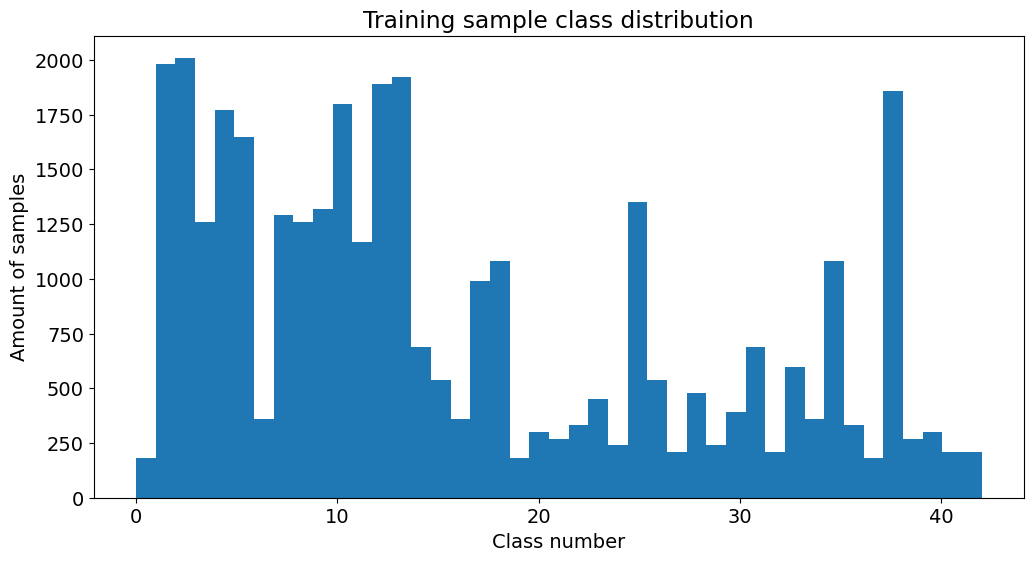

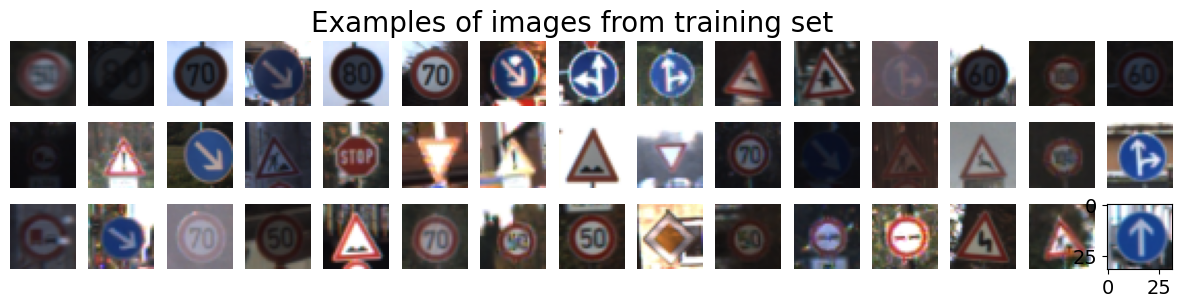

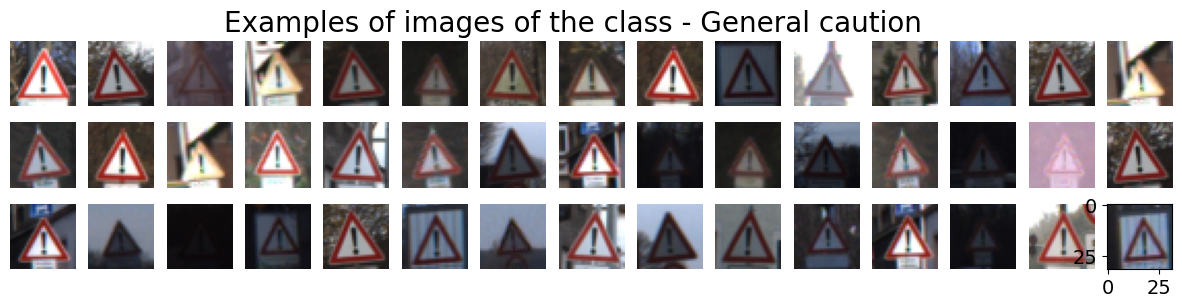

In [9]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(12,6))
n, bins, patches = plt.hist(y_train, len(set(y_train)))
plt.xlabel('Class number')
plt.ylabel('Amount of samples')
plt.title('Training sample class distribution')

draw_images_examples(X_train, 15, 3, 'Examples of images from training set')

example_class = y_train[random.randint(0, len(y_train))]

X_train_one_label = X_train[np.where(y_train==example_class)]
draw_images_examples(X_train_one_label, 15, 3, f'Examples of images of the class - {label_names["SignName"][example_class]}')

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(X, y):
    return X.to(device), y.to(device, dtype=torch.int64)

In [11]:
class TrafficSignDataset(Dataset):
    def __init__(self, path, transform=None):
        self.X, self.y, *_ = load_data(path)
        self.count = len(self.y)
        self.transform = transform

    def __getitem__(self, index):
        X = self.X[index]
        if self.transform is not None:
            X = self.transform(X)
        return X, self.y[index]

    def __len__(self):
        return self.count

In [12]:
class WrappedDataLoader:
    def __init__(self, loader, func):
        self.loader = loader
        self.func = func

    def __len__(self):
        return len(self.loader)

    def __iter__(self):
        for batch in iter(self.loader):
            yield self.func(*batch)

In [13]:
class Model(nn.Module):
    def __init__(self, kernel_size: int, fc_1_out: int, fc_2_out: int):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size)
        self.conv2 = nn.Conv2d(6, 16, kernel_size)
        self.after_conv_size = int(((32 - kernel_size + 1) / 2 - kernel_size + 1) / 2)
        print(self.after_conv_size)
        self.fc1 = nn.Linear(16 * self.after_conv_size * self.after_conv_size, fc_1_out)
        self.fc2 = nn.Linear(fc_1_out, fc_2_out)
        self.fc3 = nn.Linear(fc_2_out, 43)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * self.after_conv_size * self.after_conv_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
def loss(model, loss_func, X, y, optimizer=None):
    loss_ = loss_func(model(X), y)
    if optimizer is not None:
      loss_.backward()
      optimizer.step()
      optimizer.zero_grad()

    return loss_.item(), len(X)

In [15]:
def validate(model, loss_func, X, y):
    output = model(X)
    loss_ = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)

    return loss_.item(), torch.sum(correct).item(), len(X)

In [16]:
def fit(epochs, model, loss_func, optimizer, train_loader, valid_loader, patience=10):
    graphic_losses = []

    wait = 0
    valid_loss_min = np.Inf

    for epoch in tqdm(range(epochs)):

        model.train()

        losses = []
        for X, y  in train_loader:
          losses.append(loss(model, loss_func, X, y, optimizer))

        losses, nums = zip(*losses)
        train_loss = sum(np.multiply(losses, nums)) / sum(nums)

        model.eval()

        with torch.no_grad():

            losses = []
            for X, y in valid_loader:
              losses.append(validate(model, loss_func, X, y))

            losses, corrects, nums = zip(*losses)
            valid_loss = sum(np.multiply(losses, nums)) / sum(nums)
            valid_accuracy = sum(corrects) / sum(nums) * 100

            print(f"\nepoch: {epoch+1:3}, loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, valid accruacy: {valid_accuracy:.3f}%")

            graphic_losses.append((train_loss, valid_loss, valid_accuracy))

            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), 'model.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return graphic_losses

    return graphic_losses

In [17]:
def evaluate(model, loss_func, loader):
    model.eval()

    with torch.no_grad():
        validated_batches = []

        for X, y in loader:
          validated_batches.append(validate(model, loss_func, X, y))

        losses, corrects, nums = zip(*validated_batches)
        test_loss = sum(np.multiply(losses, nums)) / sum(nums)
        test_accuracy = sum(corrects) / sum(nums) * 100

    print(f"Test loss: {test_loss:.5f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")
    return test_loss, test_accuracy

In [18]:
def training_plots(losses_arr):
    plt.figure(figsize=(8,6))
    plt.plot([x[2] for x in losses_arr])
    plt.ylabel('Accuracy in %')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot([x[0] for x in losses_arr], label='train loss')
    plt.plot([x[1] for x in losses_arr], label='validation loss')
    plt.legend(loc="upper right")
    plt.ylabel('Losses')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

In [19]:
import os

In [30]:
def train(config, constants):
    print(os.getcwd())
    model = Model(kernel_size=config["kernel_size"], fc_1_out=config["fc_1_out"], fc_2_out=config["fc_2_out"]).to(device)
    criterion = constants["criterion"]
    optimizer = optim.Adam(model.parameters(), lr=constants["lr"])
    n_epochs = constants["n_epochs"]
    transforms = constants["transforms"]
    saving_model_path = os.path.join(constants["saving_model_path"], 
                                "checkpoint_{kernel_size}_{fc_1_out}.model".format(kernel_size=config["kernel_size"], fc_1_out=config["fc_1_out"]))
    # if custom_train_path is not None:
    #     train_dataset = TrafficSignDataset(custom_train_path, transform=transforms)
    # else:
    train_dataset = TrafficSignDataset(train_path, transform=transforms)
    valid_dataset = TrafficSignDataset(valid_path, transform=transforms)
    test_dataset = TrafficSignDataset(test_path, transform=transforms)

    train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
    valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
    test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

    print('\nFitting nn model')
    start_time = time.time()

    losses_arr = fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
    print(f'Fit time: {time.time() - start_time} s')

    check_point = torch.load('model.pt', map_location=device)
    model.load_state_dict(check_point)

    test_loss, test_accuracy = evaluate(model, criterion, test_loader)

    if saving_model_path is not None:
        print('Saving model')
        torch.save((model.state_dict(), optimizer.state_dict()), saving_model_path)
        checkpoint = Checkpoint.from_directory(constants["saving_model_path"])
        report(
            {"loss": test_loss, "accuracy": test_accuracy},
            checkpoint = checkpoint
        )

    # training_plots(losses_arr)

In [21]:
mean = (X_train / 256).mean((0, 1, 2))
std = (X_train / 256).std((0, 1, 2))

In [22]:
transforms_ = transforms.Compose([
    # transforms.ToImage(),
    # transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.2)),
    # transforms.RandomEqualize(),
    # transforms.ToDtype(dtype=torch.float32),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [2]:
config = {
    "fc_1_out": tune.grid_search([100, 200, 300, 400, 500]),
    "kernel_size": tune.grid_search([5]),
    "fc_2_out": tune.grid_search([100, 200, 300, 400, 500])
}

NameError: name 'tune' is not defined

In [34]:
constants = {"transforms": transforms_,
    "criterion": nn.CrossEntropyLoss(),
    "lr": 0.001,
    "n_epochs": 40,
    "saving_model_path": src_path + "models\\raytune"}

In [35]:
def train_model(num_samples=3, gpus_per_trial=0.125):
    # scheduler = ASHAScheduler(
    #     max_t=max_num_epochs,
    #     grace_period=1,
    #     reduction_factor=2)
    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train, constants=constants),
            resources={"cpu": 0.25, "gpu": gpus_per_trial}
        ),
        tune_config=tune.TuneConfig(
            metric="accuracy",
            mode="max",
            # scheduler=scheduler,
            num_samples=num_samples,
            # search_alg=ax_search
        ),
        param_space=config,
        run_config=RunConfig(storage_path=os.path.join(src_path, "raytune"))
    )
    results = tuner.fit()
    
    best_result = results.get_best_result("accuracy", "max")

    return best_result

In [36]:
best = train_model()

(train pid=5452) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00001_1_fc_1_out=200,kernel_size=3_2024-10-20_19-46-35
(train pid=5452) 6
(train pid=5452) 
(train pid=5452) Fitting nn model


  0%|          | 0/40 [00:00<?, ?it/s]


(train pid=1180) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00003_3_fc_1_out=400,kernel_size=3_2024-10-20_19-46-35
(train pid=1180) 6
(train pid=11340) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00002_2_fc_1_out=300,kernel_size=3_2024-10-20_19-46-35
(train pid=11340) 6
(train pid=1180) 
(train pid=11340) 
(train pid=15172) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00000_0_fc_1_out=100,kernel_size=3_2024-10-20_19-46-35
(train pid=15172) 6
(train pid=15172) 
(train pid=5452) 
(train pid=5452) epoch:   1, loss: 1.51779, valid loss: 0.86571, valid accruacy: 79.161%
(train pid=5452) Validation loss decreased (inf --> 0.865709). Saving model...
(train pid=15

  0%|          | 0/40 [00:00<?, ?it/s] [repeated 3x across cluster]


(train pid=11340) 
(train pid=1180) 
(train pid=15172) 
(train pid=11412) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00006_6_fc_1_out=200,kernel_size=5_2024-10-20_19-46-35
(train pid=11412) 5
(train pid=15172) epoch:   1, loss: 1.61379, valid loss: 0.92821, valid accruacy: 74.286% [repeated 3x across cluster]
(train pid=15172) Validation loss decreased (inf --> 0.928206). Saving model... [repeated 3x across cluster]


  0%|          | 0/40 [00:00<?, ?it/s]


(train pid=11412) 
(train pid=11412) Fitting nn model
(train pid=1544) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00005_5_fc_1_out=100,kernel_size=5_2024-10-20_19-46-35
(train pid=1544) 5
(train pid=1544) 


  0%|          | 0/40 [00:00<?, ?it/s]


(train pid=10768) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00007_7_fc_1_out=300,kernel_size=5_2024-10-20_19-46-35
(train pid=10768) 5
(train pid=11160) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00004_4_fc_1_out=500,kernel_size=3_2024-10-20_19-46-35
(train pid=11160) 6
(train pid=11160) 
(train pid=10768) 


  0%|          | 0/40 [00:00<?, ?it/s] [repeated 2x across cluster]


(train pid=5452) 
(train pid=5452) epoch:   2, loss: 0.35415, valid loss: 0.56639, valid accruacy: 85.714%
(train pid=5452) Validation loss decreased (0.865709 --> 0.566386). Saving model...
(train pid=10768) Fitting nn model [repeated 3x across cluster]
(train pid=1180) 
(train pid=11340) 
(train pid=15172) 
(train pid=11412) 
(train pid=11412) Validation loss decreased (inf --> 0.575602). Saving model...
(train pid=11412) epoch:   1, loss: 1.20664, valid loss: 0.57560, valid accruacy: 83.311% [repeated 4x across cluster]
(train pid=15172) Validation loss decreased (0.928206 --> 0.645673). Saving model... [repeated 3x across cluster]


  2%|▎         | 1/40 [00:31<20:27, 31.48s/it] [repeated 4x across cluster]


(train pid=1544) 


  2%|▎         | 1/40 [00:32<20:50, 32.07s/it] [repeated 2x across cluster]


(train pid=11160) 
(train pid=11160) Validation loss decreased (inf --> 0.777905). Saving model... [repeated 2x across cluster]
(train pid=11160) epoch:   1, loss: 1.49906, valid loss: 0.77791, valid accruacy: 76.281% [repeated 2x across cluster]
(train pid=10768) 


  8%|▊         | 3/40 [01:18<16:57, 27.50s/it] [repeated 2x across cluster]


(train pid=5452) 
(train pid=5452) Validation loss decreased (0.566386 --> 0.456142). Saving model...
(train pid=10768) Validation loss decreased (inf --> 0.610153). Saving model...
(train pid=5452) epoch:   3, loss: 0.19033, valid loss: 0.45614, valid accruacy: 88.503% [repeated 2x across cluster]
(train pid=1180) 
(train pid=11340) 
(train pid=15172) 


  5%|▌         | 2/40 [01:04<20:30, 32.38s/it] [repeated 4x across cluster]


(train pid=11412) 
(train pid=11412) Validation loss decreased (0.575602 --> 0.366476). Saving model... [repeated 4x across cluster]
(train pid=11412) epoch:   2, loss: 0.22274, valid loss: 0.36648, valid accruacy: 90.363% [repeated 4x across cluster]
(train pid=1544) 


  5%|▌         | 2/40 [01:05<20:50, 32.91s/it] [repeated 2x across cluster]


(train pid=11160) 
(train pid=11160) Validation loss decreased (0.777905 --> 0.462711). Saving model... [repeated 2x across cluster]
(train pid=11160) epoch:   2, loss: 0.32706, valid loss: 0.46271, valid accruacy: 85.624% [repeated 2x across cluster]
(train pid=10768) 


 10%|█         | 4/40 [01:52<17:49, 29.72s/it] [repeated 2x across cluster]


(train pid=5452) 
(train pid=5452) Validation loss decreased (0.456142 --> 0.425641). Saving model... [repeated 2x across cluster]
(train pid=5452) epoch:   4, loss: 0.12488, valid loss: 0.42564, valid accruacy: 89.025% [repeated 2x across cluster]
(train pid=1180) 
(train pid=11340) 
(train pid=15172) 


  8%|▊         | 3/40 [01:36<19:58, 32.40s/it] [repeated 4x across cluster]


(train pid=11412) 
(train pid=15172) Validation loss decreased (0.526011 --> 0.471007). Saving model...
(train pid=11412) epoch:   3, loss: 0.10977, valid loss: 0.49138, valid accruacy: 88.095% [repeated 4x across cluster]
(train pid=1544) 
(train pid=1544) Validation loss decreased (0.437697 --> 0.357629). Saving model...


  8%|▊         | 3/40 [01:37<20:00, 32.43s/it] [repeated 2x across cluster]


(train pid=11160) 
(train pid=11160) epoch:   3, loss: 0.15077, valid loss: 0.41323, valid accruacy: 88.503% [repeated 2x across cluster]
(train pid=10768) 


 12%|█▎        | 5/40 [02:24<17:55, 30.72s/it] [repeated 2x across cluster]


(train pid=5452) 
(train pid=10768) Validation loss decreased (0.414514 --> 0.339356). Saving model... [repeated 2x across cluster]
(train pid=5452) epoch:   5, loss: 0.09518, valid loss: 0.50394, valid accruacy: 89.478% [repeated 2x across cluster]
(train pid=1180) 
(train pid=11340) 
(train pid=15172) 


 10%|█         | 4/40 [02:08<19:15, 32.09s/it] [repeated 4x across cluster]


(train pid=11412) 
(train pid=11412) Validation loss decreased (0.366476 --> 0.336048). Saving model... [repeated 2x across cluster]
(train pid=11412) epoch:   4, loss: 0.07629, valid loss: 0.33605, valid accruacy: 91.655% [repeated 4x across cluster]
(train pid=1544) 


 10%|█         | 4/40 [02:09<19:16, 32.13s/it] [repeated 2x across cluster]


(train pid=11160) 
(train pid=11160) epoch:   4, loss: 0.09367, valid loss: 0.46206, valid accruacy: 88.050% [repeated 2x across cluster]
(train pid=10768) 


 15%|█▌        | 6/40 [02:56<17:34, 31.02s/it] [repeated 2x across cluster]


(train pid=5452) 
(train pid=5452) epoch:   6, loss: 0.06916, valid loss: 0.42866, valid accruacy: 90.816% [repeated 2x across cluster]
(train pid=1180) 
(train pid=1180) Validation loss decreased (0.499135 --> 0.465305). Saving model...
(train pid=11340) 
(train pid=15172) 


 12%|█▎        | 5/40 [02:40<18:37, 31.92s/it] [repeated 4x across cluster]


(train pid=11412) 
(train pid=11412) epoch:   5, loss: 0.05489, valid loss: 0.39502, valid accruacy: 90.907% [repeated 4x across cluster]
(train pid=11340) Validation loss decreased (0.476417 --> 0.461942). Saving model...
(train pid=1544) 
(train pid=1544) Validation loss decreased (0.357629 --> 0.354790). Saving model...


 12%|█▎        | 5/40 [02:40<18:35, 31.86s/it] [repeated 2x across cluster]


(train pid=10768) 
(train pid=10768) epoch:   5, loss: 0.06239, valid loss: 0.39721, valid accruacy: 91.315% [repeated 2x across cluster]
(train pid=11160) 


 18%|█▊        | 7/40 [03:27<17:08, 31.16s/it] [repeated 2x across cluster]


(train pid=5452) 
(train pid=11160) Validation loss decreased (0.413232 --> 0.393862). Saving model...
(train pid=5452) epoch:   7, loss: 0.05239, valid loss: 0.49059, valid accruacy: 90.363% [repeated 2x across cluster]
(train pid=1180) 
(train pid=11340) 
(train pid=15172) 
(train pid=15172) Validation loss decreased (0.411031 --> 0.392922). Saving model...


 15%|█▌        | 6/40 [03:12<18:13, 32.15s/it] [repeated 4x across cluster]


(train pid=11412) 
(train pid=11412) epoch:   6, loss: 0.04190, valid loss: 0.40759, valid accruacy: 90.794% [repeated 4x across cluster]
(train pid=1544) 


 15%|█▌        | 6/40 [03:13<18:12, 32.14s/it] [repeated 2x across cluster]


(train pid=10768) 
(train pid=10768) epoch:   6, loss: 0.04610, valid loss: 0.43624, valid accruacy: 90.726% [repeated 2x across cluster]
(train pid=11160) 


 20%|██        | 8/40 [04:01<16:59, 31.87s/it] [repeated 2x across cluster]


(train pid=5452) 
(train pid=5452) epoch:   8, loss: 0.04705, valid loss: 0.54525, valid accruacy: 89.977% [repeated 2x across cluster]
(train pid=11340) 
(train pid=11340) Validation loss decreased (0.461942 --> 0.440562). Saving model...
(train pid=1180) 
(train pid=15172) 


 18%|█▊        | 7/40 [03:45<17:42, 32.19s/it] [repeated 4x across cluster]


(train pid=11412) 
(train pid=11412) epoch:   7, loss: 0.03601, valid loss: 0.30426, valid accruacy: 93.197% [repeated 4x across cluster]
(train pid=11412) Validation loss decreased (0.336048 --> 0.304258). Saving model...
(train pid=1544) 
(train pid=1544) Validation loss decreased (0.354790 --> 0.342760). Saving model...


 18%|█▊        | 7/40 [03:46<17:45, 32.30s/it] [repeated 2x across cluster]


(train pid=11160) 
(train pid=11160) epoch:   7, loss: 0.03709, valid loss: 0.46628, valid accruacy: 89.932% [repeated 2x across cluster]
(train pid=10768) 


 22%|██▎       | 9/40 [04:33<16:33, 32.04s/it] [repeated 2x across cluster]


(train pid=5452) 
(train pid=5452) Validation loss decreased (0.425641 --> 0.402515). Saving model...
(train pid=5452) epoch:   9, loss: 0.04393, valid loss: 0.40251, valid accruacy: 91.134% [repeated 2x across cluster]
(train pid=11340) 
(train pid=11340) Validation loss decreased (0.440562 --> 0.437206). Saving model...
(train pid=1180) 
(train pid=15172) 


 20%|██        | 8/40 [04:16<17:01, 31.91s/it] [repeated 4x across cluster]


(train pid=11412) 
(train pid=11412) epoch:   8, loss: 0.03236, valid loss: 0.36756, valid accruacy: 92.925% [repeated 4x across cluster]
(train pid=1544) 


 20%|██        | 8/40 [04:17<17:03, 31.99s/it] [repeated 2x across cluster]


(train pid=11160) 
(train pid=11160) epoch:   8, loss: 0.03688, valid loss: 0.43343, valid accruacy: 90.612% [repeated 2x across cluster]
(train pid=10768) 


 25%|██▌       | 10/40 [05:04<15:53, 31.77s/it] [repeated 2x across cluster]


(train pid=5452) 
(train pid=5452) epoch:  10, loss: 0.03492, valid loss: 0.52103, valid accruacy: 89.705% [repeated 2x across cluster]
(train pid=11340) 
(train pid=1180) 
(train pid=1180) Validation loss decreased (0.465305 --> 0.369893). Saving model...
(train pid=15172) 


 22%|██▎       | 9/40 [04:48<16:29, 31.92s/it] [repeated 4x across cluster]


(train pid=11412) 
(train pid=11412) epoch:   9, loss: 0.02947, valid loss: 0.36200, valid accruacy: 92.880% [repeated 4x across cluster]
(train pid=1544) 


 22%|██▎       | 9/40 [04:49<16:32, 32.01s/it] [repeated 2x across cluster]


(train pid=10768) 
(train pid=10768) epoch:   9, loss: 0.02908, valid loss: 0.44968, valid accruacy: 93.537% [repeated 2x across cluster]
(train pid=11160) 


 28%|██▊       | 11/40 [05:37<15:34, 32.22s/it] [repeated 2x across cluster]


(train pid=5452) 
(train pid=5452) epoch:  11, loss: 0.03139, valid loss: 0.73679, valid accruacy: 89.025% [repeated 2x across cluster]
(train pid=11340) 
(train pid=11340) Validation loss decreased (0.437206 --> 0.399989). Saving model...
(train pid=1180) 
(train pid=15172) 


 25%|██▌       | 10/40 [05:21<16:10, 32.36s/it] [repeated 4x across cluster]


(train pid=11412) 
(train pid=11412) epoch:  10, loss: 0.02361, valid loss: 0.27274, valid accruacy: 94.444% [repeated 4x across cluster]
(train pid=11412) Validation loss decreased (0.304258 --> 0.272737). Saving model...
(train pid=1544) 


 25%|██▌       | 10/40 [05:22<16:10, 32.34s/it] [repeated 2x across cluster]


(train pid=10768) 
(train pid=10768) epoch:  10, loss: 0.02730, valid loss: 0.34991, valid accruacy: 92.766% [repeated 2x across cluster]
(train pid=11160) 
(train pid=11160) Validation loss decreased (0.393862 --> 0.373201). Saving model...


 30%|███       | 12/40 [06:11<15:15, 32.69s/it] [repeated 2x across cluster]


(train pid=5452) 
(train pid=5452) epoch:  12, loss: 0.02962, valid loss: 0.46336, valid accruacy: 90.862% [repeated 2x across cluster]
(train pid=11340) 
(train pid=1180) 
(train pid=1180) Validation loss decreased (0.369893 --> 0.365284). Saving model...
(train pid=15172) 


 28%|██▊       | 11/40 [05:53<15:36, 32.29s/it] [repeated 4x across cluster]


(train pid=11412) 
(train pid=11412) epoch:  11, loss: 0.01743, valid loss: 0.36968, valid accruacy: 92.766% [repeated 4x across cluster]
(train pid=15172) Validation loss decreased (0.392922 --> 0.316651). Saving model...
(train pid=1544) 


 28%|██▊       | 11/40 [05:54<15:35, 32.26s/it] [repeated 2x across cluster]


(train pid=10768) 
(train pid=10768) epoch:  11, loss: 0.02202, valid loss: 0.51115, valid accruacy: 92.426% [repeated 2x across cluster]
(train pid=11160) 


 32%|███▎      | 13/40 [06:43<14:35, 32.41s/it] [repeated 2x across cluster]


(train pid=5452) 
(train pid=5452) epoch:  13, loss: 0.02560, valid loss: 0.62870, valid accruacy: 90.204% [repeated 2x across cluster]
(train pid=11340) 
(train pid=1180) 
(train pid=15172) 


 30%|███       | 12/40 [06:25<15:02, 32.25s/it] [repeated 4x across cluster]


(train pid=11412) 
(train pid=11412) epoch:  12, loss: 0.02388, valid loss: 0.38277, valid accruacy: 92.721% [repeated 4x across cluster]
(train pid=1544) 


 30%|███       | 12/40 [06:27<15:06, 32.37s/it] [repeated 2x across cluster]


(train pid=10768) 
(train pid=10768) epoch:  12, loss: 0.01561, valid loss: 0.56426, valid accruacy: 92.517% [repeated 2x across cluster]
(train pid=11160) 


 35%|███▌      | 14/40 [07:14<13:58, 32.25s/it] [repeated 2x across cluster]


(train pid=11340) 
(train pid=11340) epoch:  14, loss: 0.02238, valid loss: 0.44735, valid accruacy: 89.841% [repeated 2x across cluster]
(train pid=5452) 
(train pid=1180) 
(train pid=15172) 


 32%|███▎      | 13/40 [06:58<14:31, 32.26s/it] [repeated 4x across cluster]


(train pid=11412) 
(train pid=11412) epoch:  13, loss: 0.01542, valid loss: 0.36426, valid accruacy: 92.381% [repeated 4x across cluster]
(train pid=1544) 


(train pid=10768) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 30%|███       | 12/40 [06:59<16:18, 34.96s/it]

(train pid=10768) 
(train pid=10768) Terminated Training for Early Stopping at Epoch 13
(train pid=10768) Fit time: 419.8063123226166 s
(train pid=10768) epoch:  13, loss: 0.02393, valid loss: 0.54569, valid accruacy: 91.995% [repeated 2x across cluster]
(train pid=11160) 
(train pid=10768) Test loss: 0.55484	Test accruacy: 89.470%
(train pid=10768) Saving model
(train pid=11160) epoch:  13, loss: 0.01826, valid loss: 0.39084, valid accruacy: 92.562%


(train pid=10768) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00007_7_fc_1_out=300,kernel_size=5_2024-10-20_19-46-35/checkpoint_000000)
 38%|███▊      | 15/40 [07:46<13:23, 32.13s/it]


(train pid=11340) 
(train pid=11340) epoch:  15, loss: 0.02470, valid loss: 0.66461, valid accruacy: 88.549%
(train pid=5452) 
(train pid=1180) 
(train pid=15172) 


 35%|███▌      | 14/40 [07:28<13:47, 31.82s/it] [repeated 4x across cluster]


(train pid=11412) 
(train pid=11412) epoch:  14, loss: 0.01367, valid loss: 0.36636, valid accruacy: 92.812% [repeated 4x across cluster]
(train pid=1544) 


 35%|███▌      | 14/40 [07:30<13:47, 31.81s/it] [repeated 2x across cluster]


(train pid=11160) 
(train pid=11160) epoch:  14, loss: 0.01853, valid loss: 0.44801, valid accruacy: 91.610% [repeated 2x across cluster]


 40%|████      | 16/40 [08:16<12:31, 31.33s/it]


(train pid=11340) 
(train pid=11340) epoch:  16, loss: 0.02028, valid loss: 0.51377, valid accruacy: 90.612%


 40%|████      | 16/40 [08:18<12:38, 31.60s/it]


(train pid=5452) 
(train pid=5452) epoch:  16, loss: 0.02437, valid loss: 0.58945, valid accruacy: 90.862%
(train pid=1180) 
(train pid=15172) 


 38%|███▊      | 15/40 [07:59<13:01, 31.27s/it] [repeated 3x across cluster]


(train pid=11412) 
(train pid=11412) epoch:  15, loss: 0.02109, valid loss: 0.32821, valid accruacy: 93.764% [repeated 3x across cluster]
(train pid=1544) 


 38%|███▊      | 15/40 [08:01<13:04, 31.39s/it] [repeated 2x across cluster]


(train pid=11160) 
(train pid=11160) epoch:  15, loss: 0.01653, valid loss: 0.57389, valid accruacy: 90.680% [repeated 2x across cluster]


 42%|████▎     | 17/40 [08:46<11:55, 31.13s/it]


(train pid=11340) 
(train pid=11340) epoch:  17, loss: 0.02187, valid loss: 0.53017, valid accruacy: 89.887%


 42%|████▎     | 17/40 [08:48<12:00, 31.32s/it]


(train pid=5452) 
(train pid=5452) epoch:  17, loss: 0.02036, valid loss: 0.51473, valid accruacy: 91.814%
(train pid=1180) 
(train pid=15172) 


 40%|████      | 16/40 [08:28<12:20, 30.84s/it] [repeated 3x across cluster]


(train pid=11412) 
(train pid=11412) epoch:  16, loss: 0.01287, valid loss: 0.35826, valid accruacy: 94.195% [repeated 3x across cluster]
(train pid=1544) 


 40%|████      | 16/40 [08:30<12:20, 30.83s/it] [repeated 2x across cluster]


(train pid=11160) 
(train pid=11160) epoch:  16, loss: 0.01488, valid loss: 0.44328, valid accruacy: 92.789% [repeated 2x across cluster]


 45%|████▌     | 18/40 [09:16<11:14, 30.65s/it]


(train pid=11340) 
(train pid=11340) epoch:  18, loss: 0.01430, valid loss: 0.49209, valid accruacy: 91.270%


 45%|████▌     | 18/40 [09:18<11:15, 30.71s/it]


(train pid=5452) 
(train pid=5452) epoch:  18, loss: 0.01335, valid loss: 0.55653, valid accruacy: 91.156%
(train pid=1180) 
(train pid=15172) 


 42%|████▎     | 17/40 [08:58<11:43, 30.61s/it] [repeated 3x across cluster]


(train pid=11412) 
(train pid=11412) epoch:  17, loss: 0.01943, valid loss: 0.33362, valid accruacy: 93.855% [repeated 3x across cluster]


(train pid=1544) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


(train pid=1544) 
(train pid=1544) Terminated Training for Early Stopping at Epoch 17
(train pid=1544) Fit time: 537.7942817211151 s


 42%|████▎     | 17/40 [09:00<11:41, 30.50s/it] [repeated 2x across cluster]


(train pid=11160) 
(train pid=11160) epoch:  17, loss: 0.00798, valid loss: 0.44916, valid accruacy: 92.449% [repeated 2x across cluster]
(train pid=1544) Test loss: 0.57373	Test accruacy: 90.974%
(train pid=1544) Saving model


(train pid=1544) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00005_5_fc_1_out=100,kernel_size=5_2024-10-20_19-46-35/checkpoint_000000)
 48%|████▊     | 19/40 [09:45<10:37, 30.34s/it]


(train pid=11340) 
(train pid=11340) epoch:  19, loss: 0.01973, valid loss: 0.47710, valid accruacy: 90.884%


(train pid=5452) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


(train pid=5452) 
(train pid=5452) epoch:  19, loss: 0.01307, valid loss: 0.67401, valid accruacy: 90.431%
(train pid=5452) Terminated Training for Early Stopping at Epoch 19
(train pid=5452) Fit time: 588.1445240974426 s
(train pid=1180) 
(train pid=15172) 
(train pid=5452) Test loss: 0.65942	Test accruacy: 89.161%
(train pid=5452) Saving model
(train pid=15172) epoch:  19, loss: 0.01917, valid loss: 0.49020, valid accruacy: 91.020% [repeated 2x across cluster]


(train pid=5452) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00001_1_fc_1_out=200,kernel_size=3_2024-10-20_19-46-35/checkpoint_000000)
 48%|████▊     | 19/40 [09:46<10:36, 30.31s/it] [repeated 3x across cluster]


(train pid=11412) 


 45%|████▌     | 18/40 [09:26<10:45, 29.33s/it] [repeated 2x across cluster]


(train pid=11160) 
(train pid=11160) epoch:  18, loss: 0.01145, valid loss: 0.38152, valid accruacy: 93.900% [repeated 2x across cluster]


 50%|█████     | 20/40 [10:11<09:36, 28.80s/it]


(train pid=11340) 
(train pid=11340) epoch:  20, loss: 0.01060, valid loss: 0.48439, valid accruacy: 91.565%


 50%|█████     | 20/40 [10:12<09:36, 28.84s/it]


(train pid=1180) 
(train pid=1180) epoch:  20, loss: 0.01224, valid loss: 0.59458, valid accruacy: 90.975%
(train pid=15172) 


 48%|████▊     | 19/40 [09:51<09:55, 28.35s/it] [repeated 2x across cluster]


(train pid=11412) 
(train pid=11412) epoch:  19, loss: 0.01005, valid loss: 0.44443, valid accruacy: 93.878% [repeated 2x across cluster]
(train pid=11160) 
(train pid=2948) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00008_8_fc_1_out=400,kernel_size=5_2024-10-20_19-46-35
(train pid=2948) 5


 48%|████▊     | 19/40 [09:51<09:44, 27.84s/it]


(train pid=2948) 
(train pid=2948) Fitting nn model
(train pid=11160) epoch:  19, loss: 0.02064, valid loss: 0.49394, valid accruacy: 91.814%


 50%|█████     | 20/40 [10:36<10:36, 31.83s/it]
(train pid=11340) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

(train pid=11340) 
(train pid=11340) epoch:  21, loss: 0.02716, valid loss: 0.44256, valid accruacy: 91.837%
(train pid=11340) Terminated Training for Early Stopping at Epoch 21
(train pid=11340) Fit time: 636.7900938987732 s
(train pid=1180) 
(train pid=15172) 
(train pid=11340) Test loss: 0.80996	Test accruacy: 88.670%
(train pid=11340) Saving model
(train pid=15172) epoch:  21, loss: 0.02386, valid loss: 0.48735, valid accruacy: 91.429% [repeated 2x across cluster]


(train pid=11340) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00002_2_fc_1_out=300,kernel_size=3_2024-10-20_19-46-35/checkpoint_000000)
 52%|█████▎    | 21/40 [10:37<08:49, 27.88s/it] [repeated 2x across cluster]
(train pid=11412) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless 

(train pid=11412) 
(train pid=11412) Terminated Training for Early Stopping at Epoch 20
(train pid=11412) Fit time: 617.7309763431549 s


 48%|████▊     | 19/40 [10:17<11:22, 32.49s/it] [repeated 2x across cluster]


(train pid=11160) 
(train pid=11160) epoch:  20, loss: 0.01044, valid loss: 0.46576, valid accruacy: 92.562% [repeated 2x across cluster]
(train pid=11412) Test loss: 0.56764	Test accruacy: 92.233%
(train pid=11412) Saving model
(train pid=11160) Terminated Training for Early Stopping at Epoch 20
(train pid=11160) Fit time: 617.5384469032288 s
(train pid=2948) 
(train pid=2948) Validation loss decreased (inf --> 0.645812). Saving model...


(train pid=11160) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(train pid=11412) Checkpoint successfully creat

(train pid=2948) epoch:   1, loss: 1.33515, valid loss: 0.64581, valid accruacy: 82.585%


 52%|█████▎    | 21/40 [11:03<10:00, 31.58s/it]
(train pid=1180) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


(train pid=1180) 
(train pid=1180) epoch:  22, loss: 0.01175, valid loss: 0.46666, valid accruacy: 92.585%
(train pid=1180) Terminated Training for Early Stopping at Epoch 22
(train pid=1180) Fit time: 663.3736872673035 s
(train pid=11160) Test loss: 0.54953	Test accruacy: 91.093%
(train pid=11160) Saving model
(train pid=15172) 
(train pid=1180) Test loss: 0.66854	Test accruacy: 88.987%
(train pid=1180) Saving model
(train pid=15172) epoch:  22, loss: 0.01795, valid loss: 0.51390, valid accruacy: 92.585%
(train pid=15172) Terminated Training for Early Stopping at Epoch 22
(train pid=15172) Fit time: 662.4842946529388 s


(train pid=1180) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00003_3_fc_1_out=400,kernel_size=3_2024-10-20_19-46-35/checkpoint_000000)
 52%|█████▎    | 21/40 [11:02<09:59, 31.54s/it]
(train pid=15172) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowliste

(train pid=2948) 
(train pid=2948) epoch:   2, loss: 0.24501, valid loss: 0.43428, valid accruacy: 87.914%
(train pid=2948) Validation loss decreased (0.645812 --> 0.434278). Saving model...
(train pid=15172) Test loss: 0.57911	Test accruacy: 90.800%
(train pid=15172) Saving model
(train pid=7284) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00009_9_fc_1_out=500,kernel_size=5_2024-10-20_19-46-35
(train pid=7284) 5
(train pid=7284) 
(train pid=7284) Fitting nn model


  0%|          | 0/40 [00:00<?, ?it/s]


(train pid=2948) 
(train pid=2948) epoch:   3, loss: 0.12444, valid loss: 0.35763, valid accruacy: 90.794%
(train pid=2948) Validation loss decreased (0.434278 --> 0.357632). Saving model...


  8%|▊         | 3/40 [01:04<12:27, 20.19s/it]


(train pid=10752) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00010_10_fc_1_out=100,kernel_size=3_2024-10-20_19-46-35
(train pid=10752) 6
(train pid=10752) 


  2%|▎         | 1/40 [00:22<14:36, 22.48s/it]


(train pid=2948) 
(train pid=2948) epoch:   4, loss: 0.08144, valid loss: 0.40072, valid accruacy: 91.655%
(train pid=10752) Fitting nn model
(train pid=7284) 
(train pid=7284) epoch:   1, loss: 1.23120, valid loss: 0.47919, valid accruacy: 86.440%
(train pid=7284) Validation loss decreased (inf --> 0.479195). Saving model...
(train pid=10752) 
(train pid=2472) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00011_11_fc_1_out=200,kernel_size=3_2024-10-20_19-46-35
(train pid=2472) 6
(train pid=10752) epoch:   1, loss: 1.70218, valid loss: 1.16659, valid accruacy: 65.011%
(train pid=10752) Validation loss decreased (inf --> 1.166592). Saving model...
(train pid=2472) 
(train pid=2472) Fitting nn model


 12%|█▎        | 5/40 [01:45<11:57, 20.50s/it]


(train pid=2948) 
(train pid=2948) epoch:   5, loss: 0.06259, valid loss: 0.35807, valid accruacy: 92.449%
(train pid=7284) 
(train pid=7284) Validation loss decreased (0.479195 --> 0.320987). Saving model...
(train pid=9688) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00013_13_fc_1_out=400,kernel_size=3_2024-10-20_19-46-35
(train pid=9688) 6
(train pid=7036) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00012_12_fc_1_out=300,kernel_size=3_2024-10-20_19-46-35
(train pid=7036) 6
(train pid=9688) 
(train pid=7036) 
(train pid=7036) Fitting nn model [repeated 2x across cluster]


  5%|▌         | 2/40 [00:44<13:58, 22.06s/it] [repeated 2x across cluster]


(train pid=10752) 
(train pid=10752) epoch:   2, loss: 0.52053, valid loss: 0.73622, valid accruacy: 78.367% [repeated 2x across cluster]
(train pid=10752) Validation loss decreased (1.166592 --> 0.736221). Saving model...
(train pid=812) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00014_14_fc_1_out=500,kernel_size=3_2024-10-20_19-46-35
(train pid=812) 6
(train pid=812) 
(train pid=812) Fitting nn model


  0%|          | 0/40 [00:00<?, ?it/s]


(train pid=2472) 
(train pid=2472) epoch:   1, loss: 1.76073, valid loss: 1.15264, valid accruacy: 66.327%
(train pid=2472) Validation loss decreased (inf --> 1.152635). Saving model...


  2%|▎         | 1/40 [00:27<18:10, 27.97s/it]


(train pid=2948) 
(train pid=2948) Validation loss decreased (0.357632 --> 0.318101). Saving model...
(train pid=7284) 


  2%|▎         | 1/40 [00:29<19:13, 29.57s/it] [repeated 3x across cluster]


(train pid=9688) 
(train pid=9688) epoch:   1, loss: 1.35952, valid loss: 0.74070, valid accruacy: 78.526% [repeated 3x across cluster]
(train pid=9688) Validation loss decreased (inf --> 0.740698). Saving model...
(train pid=7036) 
(train pid=7036) Validation loss decreased (inf --> 0.719718). Saving model...
(train pid=7284) Validation loss decreased (0.320987 --> 0.307636). Saving model...
(train pid=10752) 
(train pid=10752) Validation loss decreased (0.736221 --> 0.541924). Saving model...
(train pid=11840) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00015_15_fc_1_out=100,kernel_size=5_2024-10-20_19-46-35
(train pid=11840) 5
(train pid=10752) epoch:   3, loss: 0.27053, valid loss: 0.54192, valid accruacy: 83.492% [repeated 2x across cluster]
(train pid=11840) 
(train pid=11840) Fitting nn model


  2%|▎         | 1/40 [00:31<20:24, 31.41s/it]


(train pid=812) 
(train pid=812) Validation loss decreased (inf --> 0.828722). Saving model...
(train pid=812) epoch:   1, loss: 1.46130, valid loss: 0.82872, valid accruacy: 78.549%


  5%|▌         | 2/40 [00:59<19:00, 30.02s/it]


(train pid=2472) 
(train pid=2472) epoch:   2, loss: 0.46185, valid loss: 0.75516, valid accruacy: 80.204%
(train pid=2472) Validation loss decreased (1.152635 --> 0.755165). Saving model...
(train pid=2948) 
(train pid=7284) 


  5%|▌         | 2/40 [01:01<19:38, 31.01s/it] [repeated 3x across cluster]


(train pid=9688) 
(train pid=9688) epoch:   2, loss: 0.27374, valid loss: 0.43937, valid accruacy: 88.163% [repeated 3x across cluster]
(train pid=9688) Validation loss decreased (0.740698 --> 0.439371). Saving model...
(train pid=7036) 
(train pid=7036) Validation loss decreased (0.719718 --> 0.439054). Saving model...
(train pid=10752) 
(train pid=11840) 
(train pid=11840) Validation loss decreased (inf --> 0.677737). Saving model...
(train pid=11840) epoch:   1, loss: 1.42607, valid loss: 0.67774, valid accruacy: 79.887% [repeated 3x across cluster]


  2%|▎         | 1/40 [00:36<23:40, 36.42s/it] [repeated 3x across cluster]


(train pid=812) 
(train pid=812) Validation loss decreased (0.828722 --> 0.506149). Saving model...
(train pid=812) epoch:   2, loss: 0.31257, valid loss: 0.50615, valid accruacy: 87.755%


  8%|▊         | 3/40 [01:34<19:47, 32.10s/it]


(train pid=2472) 
(train pid=2472) epoch:   3, loss: 0.23664, valid loss: 0.76546, valid accruacy: 81.111%
(train pid=2948) 
(train pid=7284) 


  8%|▊         | 3/40 [01:36<20:11, 32.75s/it] [repeated 3x across cluster]


(train pid=9688) 
(train pid=9688) epoch:   3, loss: 0.14078, valid loss: 0.45991, valid accruacy: 88.912% [repeated 3x across cluster]
(train pid=7036) 
(train pid=7036) Validation loss decreased (0.439054 --> 0.383975). Saving model...
(train pid=10752) 


  5%|▌         | 2/40 [01:10<22:19, 35.26s/it] [repeated 3x across cluster]


(train pid=11840) 
(train pid=11840) epoch:   2, loss: 0.27905, valid loss: 0.54969, valid accruacy: 85.760% [repeated 3x across cluster]
(train pid=11840) Validation loss decreased (0.677737 --> 0.549685). Saving model... [repeated 2x across cluster]


  8%|▊         | 3/40 [01:40<20:55, 33.93s/it]


(train pid=812) 
(train pid=812) epoch:   3, loss: 0.15815, valid loss: 0.42485, valid accruacy: 88.934%
(train pid=812) Validation loss decreased (0.506149 --> 0.424851). Saving model...


 10%|█         | 4/40 [02:07<19:38, 32.73s/it]


(train pid=2472) 
(train pid=2472) epoch:   4, loss: 0.15597, valid loss: 0.67934, valid accruacy: 83.923%
(train pid=2472) Validation loss decreased (0.755165 --> 0.679341). Saving model...
(train pid=2948) 
(train pid=7284) 


 10%|█         | 4/40 [02:10<19:56, 33.24s/it] [repeated 3x across cluster]


(train pid=9688) 
(train pid=9688) epoch:   4, loss: 0.08803, valid loss: 0.40665, valid accruacy: 89.456% [repeated 3x across cluster]
(train pid=9688) Validation loss decreased (0.439371 --> 0.406653). Saving model...
(train pid=7036) 
(train pid=10752) 
(train pid=10752) Validation loss decreased (0.531842 --> 0.524139). Saving model...


  8%|▊         | 3/40 [01:44<21:09, 34.31s/it] [repeated 3x across cluster]


(train pid=11840) 
(train pid=11840) epoch:   3, loss: 0.14652, valid loss: 0.43689, valid accruacy: 88.163% [repeated 3x across cluster]
(train pid=11840) Validation loss decreased (0.549685 --> 0.436895). Saving model...


 10%|█         | 4/40 [02:14<20:12, 33.68s/it]


(train pid=812) 
(train pid=812) Validation loss decreased (0.424851 --> 0.362427). Saving model...
(train pid=812) epoch:   4, loss: 0.10046, valid loss: 0.36243, valid accruacy: 90.385%


 12%|█▎        | 5/40 [02:40<19:08, 32.81s/it]


(train pid=2472) 
(train pid=2472) epoch:   5, loss: 0.11385, valid loss: 0.66426, valid accruacy: 85.805%
(train pid=2948) 
(train pid=2472) Validation loss decreased (0.679341 --> 0.664258). Saving model...
(train pid=7284) 


 12%|█▎        | 5/40 [02:43<19:17, 33.07s/it] [repeated 3x across cluster]


(train pid=9688) 
(train pid=9688) Validation loss decreased (0.406653 --> 0.401642). Saving model...
(train pid=9688) epoch:   5, loss: 0.07038, valid loss: 0.40164, valid accruacy: 90.113% [repeated 3x across cluster]
(train pid=7036) 
(train pid=10752) 


 10%|█         | 4/40 [02:16<20:06, 33.51s/it] [repeated 3x across cluster]


(train pid=11840) 
(train pid=10752) Validation loss decreased (0.524139 --> 0.478216). Saving model...
(train pid=11840) epoch:   4, loss: 0.09738, valid loss: 0.44970, valid accruacy: 90.295% [repeated 3x across cluster]


 12%|█▎        | 5/40 [02:46<19:23, 33.24s/it]


(train pid=812) 
(train pid=812) Validation loss decreased (0.362427 --> 0.311354). Saving model...
(train pid=812) epoch:   5, loss: 0.07409, valid loss: 0.31135, valid accruacy: 92.063%


 15%|█▌        | 6/40 [03:13<18:39, 32.93s/it]


(train pid=2472) 
(train pid=2472) epoch:   6, loss: 0.08693, valid loss: 0.77154, valid accruacy: 85.034%
(train pid=2948) 
(train pid=7284) 
(train pid=7284) Validation loss decreased (0.307636 --> 0.288175). Saving model...


 15%|█▌        | 6/40 [03:16<18:46, 33.14s/it] [repeated 3x across cluster]


(train pid=9688) 
(train pid=9688) epoch:   6, loss: 0.04674, valid loss: 0.42883, valid accruacy: 91.020% [repeated 3x across cluster]
(train pid=7036) 
(train pid=7036) Validation loss decreased (0.383975 --> 0.357211). Saving model...
(train pid=10752) 


 12%|█▎        | 5/40 [02:50<19:43, 33.81s/it] [repeated 3x across cluster]


(train pid=11840) 
(train pid=11840) Validation loss decreased (0.436895 --> 0.345168). Saving model...
(train pid=11840) epoch:   5, loss: 0.07177, valid loss: 0.34517, valid accruacy: 91.361% [repeated 3x across cluster]


 15%|█▌        | 6/40 [03:21<19:14, 33.96s/it]


(train pid=812) 
(train pid=812) epoch:   6, loss: 0.04943, valid loss: 0.31646, valid accruacy: 92.222%


 18%|█▊        | 7/40 [03:48<18:26, 33.52s/it]


(train pid=2472) 
(train pid=2472) epoch:   7, loss: 0.07900, valid loss: 0.70753, valid accruacy: 85.193%
(train pid=2948) 
(train pid=7284) 


 18%|█▊        | 7/40 [03:51<18:33, 33.74s/it] [repeated 3x across cluster]


(train pid=9688) 
(train pid=9688) epoch:   7, loss: 0.04105, valid loss: 0.52106, valid accruacy: 89.365% [repeated 3x across cluster]
(train pid=7036) 
(train pid=7036) Validation loss decreased (0.357211 --> 0.298509). Saving model...
(train pid=10752) 


 15%|█▌        | 6/40 [03:25<19:21, 34.16s/it] [repeated 3x across cluster]


(train pid=11840) 
(train pid=11840) epoch:   6, loss: 0.05680, valid loss: 0.41594, valid accruacy: 90.612% [repeated 3x across cluster]


 18%|█▊        | 7/40 [03:56<18:51, 34.29s/it]


(train pid=812) 
(train pid=812) epoch:   7, loss: 0.03813, valid loss: 0.36392, valid accruacy: 92.132%
(train pid=2472) 
(train pid=2472) epoch:   8, loss: 0.05670, valid loss: 0.63627, valid accruacy: 87.528%
(train pid=2472) Validation loss decreased (0.664258 --> 0.636273). Saving model...


 20%|██        | 8/40 [04:23<18:03, 33.86s/it]


(train pid=2948) 
(train pid=7284) 
(train pid=9688) 
(train pid=10752) 
(train pid=7036) 
(train pid=11840) 


 20%|██        | 8/40 [04:13<15:18, 28.70s/it] [repeated 7x across cluster]


(train pid=812) 
(train pid=812) epoch:   8, loss: 0.03294, valid loss: 0.37681, valid accruacy: 91.202% [repeated 7x across cluster]
(train pid=2472) 


 35%|███▌      | 14/40 [06:24<12:12, 28.16s/it] [repeated 2x across cluster]


(train pid=2948) 
(train pid=2948) epoch:  14, loss: 0.02354, valid loss: 0.35617, valid accruacy: 93.424% [repeated 2x across cluster]
(train pid=7284) 


 22%|██▎       | 9/40 [04:42<15:36, 30.21s/it] [repeated 2x across cluster]


(train pid=9688) 
(train pid=9688) epoch:   9, loss: 0.03156, valid loss: 0.43774, valid accruacy: 91.542% [repeated 2x across cluster]
(train pid=10752) 
(train pid=7036) 


 20%|██        | 8/40 [04:16<16:14, 30.45s/it] [repeated 3x across cluster]


(train pid=11840) 
(train pid=11840) epoch:   8, loss: 0.03965, valid loss: 0.43874, valid accruacy: 91.723% [repeated 3x across cluster]


 22%|██▎       | 9/40 [04:47<15:39, 30.32s/it]


(train pid=812) 
(train pid=812) epoch:   9, loss: 0.02920, valid loss: 0.36852, valid accruacy: 92.449%


 25%|██▌       | 10/40 [05:13<15:04, 30.13s/it]


(train pid=2472) 
(train pid=2472) epoch:  10, loss: 0.05160, valid loss: 0.55385, valid accruacy: 88.481%
(train pid=2472) Validation loss decreased (0.636273 --> 0.553855). Saving model...
(train pid=2948) 
(train pid=7284) 


 25%|██▌       | 10/40 [05:15<15:32, 31.07s/it] [repeated 3x across cluster]


(train pid=9688) 
(train pid=9688) epoch:  10, loss: 0.02437, valid loss: 0.46619, valid accruacy: 90.385% [repeated 3x across cluster]
(train pid=7284) Validation loss decreased (0.288175 --> 0.247062). Saving model...
(train pid=10752) 
(train pid=7036) 


 22%|██▎       | 9/40 [04:48<15:55, 30.81s/it] [repeated 3x across cluster]


(train pid=11840) 
(train pid=11840) epoch:   9, loss: 0.03049, valid loss: 0.42788, valid accruacy: 91.043% [repeated 3x across cluster]


 25%|██▌       | 10/40 [05:20<15:32, 31.09s/it]


(train pid=812) 
(train pid=812) epoch:  10, loss: 0.02867, valid loss: 0.36140, valid accruacy: 92.630%


 28%|██▊       | 11/40 [05:46<15:00, 31.05s/it]


(train pid=2472) 
(train pid=2472) epoch:  11, loss: 0.03549, valid loss: 0.65185, valid accruacy: 87.483%


(train pid=2948) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


(train pid=2948) 
(train pid=2948) Terminated Training for Early Stopping at Epoch 16
(train pid=2948) Fit time: 451.18830394744873 s
(train pid=7284) 


 28%|██▊       | 11/40 [05:48<15:18, 31.68s/it] [repeated 3x across cluster]


(train pid=9688) 
(train pid=9688) epoch:  11, loss: 0.02102, valid loss: 0.44611, valid accruacy: 91.791% [repeated 3x across cluster]
(train pid=10752) 
(train pid=7036) 
(train pid=2948) Test loss: 0.44949	Test accruacy: 91.045%
(train pid=2948) Saving model
(train pid=7036) epoch:  11, loss: 0.01952, valid loss: 0.37106, valid accruacy: 92.698% [repeated 2x across cluster]


(train pid=2948) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00008_8_fc_1_out=400,kernel_size=5_2024-10-20_19-46-35/checkpoint_000000)
 25%|██▌       | 10/40 [05:21<15:47, 31.60s/it]


(train pid=11840) 
(train pid=11840) epoch:  10, loss: 0.02708, valid loss: 0.50726, valid accruacy: 91.361%


 28%|██▊       | 11/40 [05:53<15:18, 31.66s/it]


(train pid=812) 
(train pid=812) epoch:  11, loss: 0.02166, valid loss: 0.37631, valid accruacy: 92.902%
(train pid=2472) 


 35%|███▌      | 14/40 [07:03<13:50, 31.93s/it] [repeated 2x across cluster]


(train pid=7284) 
(train pid=7284) epoch:  14, loss: 0.01399, valid loss: 0.39488, valid accruacy: 94.240% [repeated 2x across cluster]
(train pid=9688) 
(train pid=10752) 
(train pid=7036) 


 28%|██▊       | 11/40 [05:52<15:07, 31.30s/it] [repeated 4x across cluster]


(train pid=11840) 
(train pid=11840) epoch:  11, loss: 0.03025, valid loss: 0.52614, valid accruacy: 92.925% [repeated 4x across cluster]


 30%|███       | 12/40 [06:24<14:40, 31.44s/it]


(train pid=812) 
(train pid=812) Validation loss decreased (0.311354 --> 0.297283). Saving model...
(train pid=812) epoch:  12, loss: 0.02591, valid loss: 0.29728, valid accruacy: 93.061%


 32%|███▎      | 13/40 [06:50<14:04, 31.29s/it]


(train pid=2472) 
(train pid=2472) epoch:  13, loss: 0.02900, valid loss: 0.76754, valid accruacy: 86.871%
(train pid=7284) 


 32%|███▎      | 13/40 [06:51<14:08, 31.41s/it] [repeated 2x across cluster]


(train pid=9688) 
(train pid=9688) epoch:  13, loss: 0.02620, valid loss: 0.47219, valid accruacy: 91.905% [repeated 2x across cluster]
(train pid=10752) 
(train pid=7036) 


 30%|███       | 12/40 [06:22<14:23, 30.83s/it] [repeated 3x across cluster]


(train pid=11840) 
(train pid=11840) epoch:  12, loss: 0.03001, valid loss: 0.51429, valid accruacy: 91.361% [repeated 3x across cluster]


 32%|███▎      | 13/40 [06:53<13:53, 30.87s/it]


(train pid=812) 
(train pid=812) Validation loss decreased (0.297283 --> 0.282900). Saving model...
(train pid=812) epoch:  13, loss: 0.02233, valid loss: 0.28290, valid accruacy: 94.490%


 35%|███▌      | 14/40 [07:20<13:25, 30.97s/it]


(train pid=2472) 
(train pid=2472) epoch:  14, loss: 0.02665, valid loss: 0.70684, valid accruacy: 88.322%
(train pid=7284) 


 35%|███▌      | 14/40 [07:21<13:28, 31.09s/it] [repeated 2x across cluster]


(train pid=9688) 
(train pid=9688) epoch:  14, loss: 0.01574, valid loss: 0.52899, valid accruacy: 91.247% [repeated 2x across cluster]
(train pid=10752) 
(train pid=7036) 


 32%|███▎      | 13/40 [06:53<13:56, 30.98s/it] [repeated 3x across cluster]


(train pid=11840) 
(train pid=11840) epoch:  13, loss: 0.02074, valid loss: 0.37461, valid accruacy: 92.245% [repeated 3x across cluster]


 35%|███▌      | 14/40 [07:25<13:30, 31.16s/it]


(train pid=812) 
(train pid=812) epoch:  14, loss: 0.01218, valid loss: 0.36970, valid accruacy: 92.540%


 38%|███▊      | 15/40 [07:51<12:58, 31.15s/it]


(train pid=2472) 
(train pid=2472) epoch:  15, loss: 0.02933, valid loss: 0.72198, valid accruacy: 87.392%
(train pid=7284) 


(train pid=9688) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 35%|███▌      | 14/40 [07:53<14:38, 33.80s/it] 

(train pid=9688) 
(train pid=9688) Terminated Training for Early Stopping at Epoch 15
(train pid=9688) Fit time: 473.38759446144104 s
(train pid=9688) epoch:  15, loss: 0.02062, valid loss: 0.44026, valid accruacy: 92.517% [repeated 2x across cluster]
(train pid=10752) 
(train pid=7036) 


(train pid=10752) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 35%|███▌      | 14/40 [07:24<13:25, 30.96s/it]

(train pid=11840) 
(train pid=10752) Terminated Training for Early Stopping at Epoch 17
(train pid=10752) Fit time: 514.7948915958405 s
(train pid=11840) epoch:  14, loss: 0.01628, valid loss: 0.46349, valid accruacy: 92.177% [repeated 3x across cluster]
(train pid=10752) Test loss: 0.69468	Test accruacy: 87.284%
(train pid=10752) Saving model


(train pid=9688) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00013_13_fc_1_out=400,kernel_size=3_2024-10-20_19-46-35/checkpoint_000000)
 38%|███▊      | 15/40 [07:54<12:45, 30.61s/it]
(train pid=10752) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00010_10_fc_1_out=100,kernel_size=3_2024-10-20_19-46-35/checkpoint_000000)


(train pid=812) 
(train pid=812) epoch:  15, loss: 0.01830, valid loss: 0.37122, valid accruacy: 92.721%
(train pid=9688) Test loss: 0.55311	Test accruacy: 88.638%
(train pid=9688) Saving model


 40%|████      | 16/40 [08:20<12:09, 30.41s/it]


(train pid=2472) 
(train pid=2472) epoch:  16, loss: 0.02176, valid loss: 0.82699, valid accruacy: 87.596%
(train pid=7284) 


 40%|████      | 16/40 [08:20<11:56, 29.85s/it] [repeated 2x across cluster]


(train pid=7036) 
(train pid=7036) Validation loss decreased (0.298509 --> 0.281625). Saving model...
(train pid=7036) epoch:  16, loss: 0.01917, valid loss: 0.28162, valid accruacy: 94.286% [repeated 2x across cluster]


(train pid=11840) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 35%|███▌      | 14/40 [07:49<14:32, 33.55s/it]

(train pid=11840) 
(train pid=11840) Terminated Training for Early Stopping at Epoch 15
(train pid=11840) Fit time: 470.1075038909912 s
(train pid=11840) epoch:  15, loss: 0.02123, valid loss: 0.37676, valid accruacy: 93.673%
(train pid=11840) Test loss: 0.58852	Test accruacy: 90.143%
(train pid=11840) Saving model


(train pid=11840) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00015_15_fc_1_out=100,kernel_size=5_2024-10-20_19-46-35/checkpoint_000000)
 40%|████      | 16/40 [08:19<11:28, 28.67s/it]


(train pid=812) 
(train pid=812) epoch:  16, loss: 0.01544, valid loss: 0.30306, valid accruacy: 93.946%
(train pid=2472) 
(train pid=11900) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00016_16_fc_1_out=200,kernel_size=5_2024-10-20_19-46-35
(train pid=11900) 5
(train pid=11900) 
(train pid=11900) Fitting nn model
(train pid=2472) epoch:  17, loss: 0.03302, valid loss: 0.57711, valid accruacy: 89.841%


 48%|████▊     | 19/40 [09:28<09:58, 28.50s/it]


(train pid=7284) 
(train pid=7284) epoch:  19, loss: 0.01053, valid loss: 0.40377, valid accruacy: 94.739%
(train pid=7036) 


 42%|████▎     | 17/40 [08:43<10:28, 27.33s/it] [repeated 2x across cluster]


(train pid=812) 
(train pid=812) epoch:  17, loss: 0.01076, valid loss: 0.33992, valid accruacy: 93.447% [repeated 2x across cluster]
(train pid=2472) 


  2%|▎         | 1/40 [00:26<17:04, 26.26s/it] [repeated 2x across cluster]


(train pid=11900) 
(train pid=11900) Validation loss decreased (inf --> 0.565143). Saving model...
(train pid=11900) epoch:   1, loss: 1.23798, valid loss: 0.56514, valid accruacy: 83.810% [repeated 2x across cluster]
(train pid=7284) 
(train pid=7036) 


 45%|████▌     | 18/40 [09:08<09:48, 26.77s/it] [repeated 3x across cluster]


(train pid=812) 
(train pid=812) epoch:  18, loss: 0.01632, valid loss: 0.48050, valid accruacy: 91.474% [repeated 3x across cluster]
(train pid=2472) 


  5%|▌         | 2/40 [00:51<16:13, 25.61s/it] [repeated 2x across cluster]


(train pid=11900) 
(train pid=11900) Validation loss decreased (0.565143 --> 0.383837). Saving model...
(train pid=11900) epoch:   2, loss: 0.22825, valid loss: 0.38384, valid accruacy: 89.478% [repeated 2x across cluster]
(train pid=7284) 
(train pid=7036) 


 48%|████▊     | 19/40 [09:33<09:12, 26.30s/it] [repeated 3x across cluster]


(train pid=812) 
(train pid=812) epoch:  19, loss: 0.01030, valid loss: 0.42847, valid accruacy: 93.515% [repeated 3x across cluster]


(train pid=2472) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


(train pid=2472) 
(train pid=2472) Terminated Training for Early Stopping at Epoch 20
(train pid=2472) Fit time: 599.6386597156525 s


  8%|▊         | 3/40 [01:16<15:34, 25.25s/it] [repeated 2x across cluster]


(train pid=11900) 
(train pid=11900) Validation loss decreased (0.383837 --> 0.349797). Saving model...
(train pid=11900) epoch:   3, loss: 0.12114, valid loss: 0.34980, valid accruacy: 89.705% [repeated 2x across cluster]
(train pid=7284) 


(train pid=7284) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


(train pid=7036) 
(train pid=7284) Terminated Training for Early Stopping at Epoch 22
(train pid=7284) Fit time: 643.8196001052856 s
(train pid=2472) Test loss: 0.65305	Test accruacy: 88.258%
(train pid=2472) Saving model


(train pid=2472) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00011_11_fc_1_out=200,kernel_size=3_2024-10-20_19-46-35/checkpoint_000000)


(train pid=7036) epoch:  20, loss: 0.01972, valid loss: 0.45864, valid accruacy: 92.358% [repeated 2x across cluster]


 50%|█████     | 20/40 [10:00<08:43, 26.19s/it] [repeated 2x across cluster]
(train pid=7284) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00009_9_fc_1_out=500,kernel_size=5_2024-10-20_19-46-35/checkpoint_000000)
 50%|█████     | 20/40 [09:57<08:28, 25.43s/it]


(train pid=812) 
(train pid=7284) Test loss: 0.51229	Test accruacy: 93.025%
(train pid=7284) Saving model
(train pid=812) epoch:  20, loss: 0.01716, valid loss: 0.37115, valid accruacy: 93.537%
(train pid=4856) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00018_18_fc_1_out=400,kernel_size=5_2024-10-20_19-46-35
(train pid=4856) 5


  0%|          | 0/40 [00:00<?, ?it/s]


(train pid=4856) 
(train pid=4856) Fitting nn model


 10%|█         | 4/40 [01:38<14:21, 23.92s/it]


(train pid=11900) 
(train pid=11900) epoch:   4, loss: 0.08127, valid loss: 0.46282, valid accruacy: 90.091%
(train pid=15248) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00017_17_fc_1_out=300,kernel_size=5_2024-10-20_19-46-35
(train pid=15248) 5
(train pid=15248) 
(train pid=7036) 


 52%|█████▎    | 21/40 [10:20<07:51, 24.80s/it] [repeated 2x across cluster]


(train pid=812) 
(train pid=15248) Fitting nn model
(train pid=812) epoch:  21, loss: 0.00479, valid loss: 0.34925, valid accruacy: 94.150% [repeated 2x across cluster]


 12%|█▎        | 5/40 [02:02<14:05, 24.17s/it]


(train pid=11900) 
(train pid=11900) Validation loss decreased (0.349797 --> 0.309399). Saving model...
(train pid=11900) epoch:   5, loss: 0.05623, valid loss: 0.30940, valid accruacy: 91.814%


  2%|▎         | 1/40 [00:25<16:42, 25.71s/it]


(train pid=4856) 
(train pid=4856) epoch:   1, loss: 1.26915, valid loss: 0.63302, valid accruacy: 82.358%
(train pid=4856) Validation loss decreased (inf --> 0.633024). Saving model...
(train pid=7036) 
(train pid=15248) 
(train pid=4408) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00019_19_fc_1_out=500,kernel_size=5_2024-10-20_19-46-35
(train pid=4408) 5
(train pid=4408) 
(train pid=4408) Fitting nn model
(train pid=15248) epoch:   1, loss: 1.39793, valid loss: 0.65101, valid accruacy: 80.113% [repeated 2x across cluster]
(train pid=15248) Validation loss decreased (inf --> 0.651013). Saving model...


 55%|█████▌    | 22/40 [10:47<07:34, 25.24s/it]


(train pid=812) 
(train pid=812) epoch:  22, loss: 0.01920, valid loss: 0.33331, valid accruacy: 93.741%


 15%|█▌        | 6/40 [02:29<14:12, 25.07s/it]


(train pid=11900) 
(train pid=11900) epoch:   6, loss: 0.04840, valid loss: 0.35807, valid accruacy: 90.136%
(train pid=4856) 
(train pid=4856) Validation loss decreased (0.633024 --> 0.460609). Saving model...
(train pid=7036) 


  5%|▌         | 2/40 [00:53<17:00, 26.85s/it] [repeated 3x across cluster]


(train pid=15248) 
(train pid=15248) epoch:   2, loss: 0.28932, valid loss: 0.40322, valid accruacy: 87.868% [repeated 3x across cluster]


  2%|▎         | 1/40 [00:29<19:14, 29.59s/it]


(train pid=4408) 
(train pid=4408) Validation loss decreased (inf --> 0.647006). Saving model...
(train pid=15248) Validation loss decreased (0.651013 --> 0.403215). Saving model...
(train pid=4408) epoch:   1, loss: 1.22661, valid loss: 0.64701, valid accruacy: 82.041%


 55%|█████▌    | 22/40 [11:14<09:11, 30.66s/it]
(train pid=812) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


(train pid=812) 
(train pid=812) epoch:  23, loss: 0.00787, valid loss: 0.47227, valid accruacy: 93.356%
(train pid=812) Terminated Training for Early Stopping at Epoch 23
(train pid=812) Fit time: 674.8102943897247 s


 18%|█▊        | 7/40 [02:56<14:06, 25.66s/it]


(train pid=11900) 
(train pid=11900) epoch:   7, loss: 0.03887, valid loss: 0.53883, valid accruacy: 89.592%


  8%|▊         | 3/40 [01:19<16:25, 26.64s/it]


(train pid=4856) 
(train pid=4856) epoch:   3, loss: 0.11804, valid loss: 0.35208, valid accruacy: 90.794%
(train pid=4856) Validation loss decreased (0.460609 --> 0.352080). Saving model...
(train pid=812) Test loss: 0.53102	Test accruacy: 91.869%
(train pid=812) Saving model


(train pid=812) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00014_14_fc_1_out=500,kernel_size=3_2024-10-20_19-46-35/checkpoint_000000)


(train pid=7036) 


  8%|▊         | 3/40 [01:21<16:46, 27.19s/it] [repeated 2x across cluster]


(train pid=15248) 
(train pid=15248) epoch:   3, loss: 0.14355, valid loss: 0.34787, valid accruacy: 90.000% [repeated 2x across cluster]
(train pid=15248) Validation loss decreased (0.403215 --> 0.347872). Saving model...
(train pid=4408) 
(train pid=4408) Validation loss decreased (0.647006 --> 0.449960). Saving model...


 20%|██        | 8/40 [03:21<13:33, 25.43s/it] [repeated 2x across cluster]


(train pid=11900) 
(train pid=11900) epoch:   8, loss: 0.02746, valid loss: 0.41560, valid accruacy: 91.882% [repeated 2x across cluster]
(train pid=4856) 
(train pid=7036) 


 10%|█         | 4/40 [01:45<15:41, 26.15s/it] [repeated 3x across cluster]


(train pid=15248) 
(train pid=15248) epoch:   4, loss: 0.09644, valid loss: 0.38421, valid accruacy: 89.456% [repeated 3x across cluster]
(train pid=4408) 
(train pid=4408) Validation loss decreased (0.449960 --> 0.368734). Saving model...
(train pid=7452) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00020_20_fc_1_out=100,kernel_size=3_2024-10-20_19-46-35
(train pid=7452) 6
(train pid=4408) epoch:   3, loss: 0.12164, valid loss: 0.36873, valid accruacy: 89.909%
(train pid=7452) 
(train pid=7452) Fitting nn model


  8%|▊         | 3/40 [01:20<16:17, 26.41s/it]


(train pid=12488) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00021_21_fc_1_out=200,kernel_size=3_2024-10-20_19-46-35
(train pid=12488) 6


 22%|██▎       | 9/40 [03:46<13:04, 25.30s/it]


(train pid=11900) 
(train pid=11900) epoch:   9, loss: 0.02712, valid loss: 0.45176, valid accruacy: 91.156%
(train pid=12488) 
(train pid=12488) Fitting nn model


  0%|          | 0/40 [00:00<?, ?it/s]


(train pid=4856) 
(train pid=7036) 
(train pid=7036) Terminated Training for Early Stopping at Epoch 26
(train pid=7036) Fit time: 753.0483407974243 s
(train pid=7036) epoch:  26, loss: 0.01438, valid loss: 0.37177, valid accruacy: 93.923% [repeated 2x across cluster]


(train pid=7036) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 62%|██████▎   | 25/40 [12:32<07:31, 30.12s/it] 

(train pid=15248) 
(train pid=15248) Validation loss decreased (0.347872 --> 0.323077). Saving model...


 10%|█         | 4/40 [01:49<16:19, 27.21s/it] [repeated 2x across cluster]


(train pid=4408) 
(train pid=4408) epoch:   4, loss: 0.07456, valid loss: 0.35587, valid accruacy: 91.610% [repeated 2x across cluster]
(train pid=4408) Validation loss decreased (0.368734 --> 0.355871). Saving model...
(train pid=7036) Test loss: 0.50862	Test accruacy: 92.130%
(train pid=7036) Saving model


(train pid=7036) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00012_12_fc_1_out=300,kernel_size=3_2024-10-20_19-46-35/checkpoint_000000)
  2%|▎         | 1/40 [00:31<20:43, 31.87s/it]


(train pid=7452) 
(train pid=7452) Validation loss decreased (inf --> 0.862104). Saving model...
(train pid=7452) epoch:   1, loss: 1.60254, valid loss: 0.86210, valid accruacy: 74.739%


 25%|██▌       | 10/40 [04:16<13:22, 26.77s/it]


(train pid=11900) 
(train pid=11900) epoch:  10, loss: 0.02923, valid loss: 0.34500, valid accruacy: 92.834%
(train pid=4856) 
(train pid=12488) 


 15%|█▌        | 6/40 [02:41<15:30, 27.36s/it] [repeated 3x across cluster]


(train pid=15248) 
(train pid=12488) Validation loss decreased (inf --> 1.027259). Saving model...
(train pid=15248) epoch:   6, loss: 0.04718, valid loss: 0.37130, valid accruacy: 91.701% [repeated 3x across cluster]


 12%|█▎        | 5/40 [02:17<16:08, 27.69s/it]


(train pid=4408) 
(train pid=4408) epoch:   5, loss: 0.05432, valid loss: 0.40423, valid accruacy: 90.181%
(train pid=7452) 
(train pid=7452) epoch:   2, loss: 0.37430, valid loss: 0.65241, valid accruacy: 83.447%
(train pid=7452) Validation loss decreased (0.862104 --> 0.652414). Saving model...


  5%|▌         | 2/40 [00:58<18:22, 29.02s/it]


(train pid=11900) 


  5%|▌         | 2/40 [00:58<18:25, 29.08s/it] [repeated 2x across cluster]


(train pid=12488) 
(train pid=12488) epoch:   2, loss: 0.40046, valid loss: 0.63548, valid accruacy: 81.701% [repeated 2x across cluster]
(train pid=12488) Validation loss decreased (1.027259 --> 0.635484). Saving model... [repeated 2x across cluster]
(train pid=4856) 


 18%|█▊        | 7/40 [03:09<15:07, 27.49s/it] [repeated 2x across cluster]


(train pid=15248) 
(train pid=15248) epoch:   7, loss: 0.04078, valid loss: 0.38785, valid accruacy: 91.270% [repeated 2x across cluster]


 15%|█▌        | 6/40 [02:45<15:44, 27.79s/it]


(train pid=4408) 
(train pid=4408) epoch:   6, loss: 0.03938, valid loss: 0.70874, valid accruacy: 87.982%


  8%|▊         | 3/40 [01:26<17:30, 28.40s/it]


(train pid=7452) 
(train pid=7452) epoch:   3, loss: 0.21918, valid loss: 0.62455, valid accruacy: 84.331%
(train pid=7452) Validation loss decreased (0.652414 --> 0.624552). Saving model...
(train pid=11900) 
(train pid=12488) 


 20%|██        | 8/40 [03:35<14:36, 27.40s/it] [repeated 3x across cluster]


(train pid=4856) 
(train pid=4856) epoch:   8, loss: 0.03346, valid loss: 0.41915, valid accruacy: 91.020% [repeated 3x across cluster]
(train pid=12488) Validation loss decreased (0.635484 --> 0.587494). Saving model...
(train pid=15248) 


 18%|█▊        | 7/40 [03:12<15:07, 27.51s/it] [repeated 2x across cluster]


(train pid=4408) 
(train pid=4408) epoch:   7, loss: 0.04074, valid loss: 0.55723, valid accruacy: 89.773% [repeated 2x across cluster]
(train pid=2792) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00022_22_fc_1_out=300,kernel_size=3_2024-10-20_19-46-35
(train pid=2792) 6
(train pid=2792) 
(train pid=2792) Fitting nn model


 10%|█         | 4/40 [01:54<16:55, 28.20s/it]


(train pid=7452) 
(train pid=7452) epoch:   4, loss: 0.15795, valid loss: 0.53082, valid accruacy: 87.007%
(train pid=7452) Validation loss decreased (0.624552 --> 0.530817). Saving model...
(train pid=11900) 
(train pid=12488) 


 22%|██▎       | 9/40 [04:03<14:20, 27.77s/it] [repeated 3x across cluster]


(train pid=4856) 
(train pid=4856) epoch:   9, loss: 0.02257, valid loss: 0.47393, valid accruacy: 91.542% [repeated 3x across cluster]
(train pid=12488) Validation loss decreased (0.587494 --> 0.586525). Saving model...


 22%|██▎       | 9/40 [04:05<14:26, 27.96s/it]


(train pid=15248) 
(train pid=15248) epoch:   9, loss: 0.03027, valid loss: 0.42407, valid accruacy: 92.177%
(train pid=4408) 
(train pid=4408) epoch:   8, loss: 0.03128, valid loss: 0.41393, valid accruacy: 91.927%


 20%|██        | 8/40 [03:43<15:12, 28.52s/it]


(train pid=2792) 
(train pid=2792) Validation loss decreased (inf --> 0.764611). Saving model...
(train pid=2792) epoch:   1, loss: 1.39483, valid loss: 0.76461, valid accruacy: 77.166%


 12%|█▎        | 5/40 [02:25<17:05, 29.29s/it]


(train pid=7452) 
(train pid=7452) epoch:   5, loss: 0.11625, valid loss: 0.58644, valid accruacy: 84.218%
(train pid=11900) 


 12%|█▎        | 5/40 [02:25<17:05, 29.29s/it] [repeated 2x across cluster]


(train pid=12488) 
(train pid=4856) 
(train pid=4856) epoch:  10, loss: 0.02697, valid loss: 0.42319, valid accruacy: 91.905% [repeated 3x across cluster]


 25%|██▌       | 10/40 [04:38<14:39, 29.30s/it] [repeated 2x across cluster]


(train pid=15248) 
(train pid=15248) Validation loss decreased (0.323077 --> 0.306183). Saving model...
(train pid=15248) epoch:  10, loss: 0.02303, valid loss: 0.30618, valid accruacy: 92.562%


 22%|██▎       | 9/40 [04:15<15:20, 29.68s/it]


(train pid=4408) 
(train pid=4408) epoch:   9, loss: 0.03020, valid loss: 0.43511, valid accruacy: 91.701%


  5%|▌         | 2/40 [01:03<19:59, 31.57s/it]


(train pid=2792) 
(train pid=2792) Validation loss decreased (0.764611 --> 0.677290). Saving model...
(train pid=2792) epoch:   2, loss: 0.32338, valid loss: 0.67729, valid accruacy: 82.109%
(train pid=7452) 
(train pid=7452) epoch:   6, loss: 0.09341, valid loss: 0.49904, valid accruacy: 88.322%


 38%|███▊      | 15/40 [06:40<12:06, 29.06s/it] [repeated 2x across cluster]


(train pid=11900) 
(train pid=7452) Validation loss decreased (0.530817 --> 0.499041). Saving model...
(train pid=12488) 
(train pid=12488) Validation loss decreased (0.586525 --> 0.498944). Saving model...
(train pid=4856) 
(train pid=4856) epoch:  11, loss: 0.02427, valid loss: 0.46025, valid accruacy: 90.839% [repeated 3x across cluster]


 28%|██▊       | 11/40 [05:08<14:16, 29.54s/it] [repeated 3x across cluster]


(train pid=15248) 
(train pid=15248) epoch:  11, loss: 0.02414, valid loss: 0.40903, valid accruacy: 92.472%
(train pid=7980) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00023_23_fc_1_out=400,kernel_size=3_2024-10-20_19-46-35
(train pid=7980) 6
(train pid=7980) 
(train pid=7980) Fitting nn model


 25%|██▌       | 10/40 [04:46<15:03, 30.10s/it]


(train pid=4408) 
(train pid=4408) epoch:  10, loss: 0.01986, valid loss: 0.40222, valid accruacy: 92.177%


  8%|▊         | 3/40 [01:35<19:33, 31.71s/it]


(train pid=2792) 
(train pid=2792) Validation loss decreased (0.677290 --> 0.647670). Saving model...
(train pid=2792) epoch:   3, loss: 0.17614, valid loss: 0.64767, valid accruacy: 85.011%
(train pid=7452) 
(train pid=7452) epoch:   7, loss: 0.07517, valid loss: 0.49836, valid accruacy: 88.821%
(train pid=7452) Validation loss decreased (0.499041 --> 0.498362). Saving model...


 40%|████      | 16/40 [07:12<12:01, 30.08s/it]


(train pid=11900) 
(train pid=12488) 
(train pid=12488) epoch:   7, loss: 0.06552, valid loss: 0.54005, valid accruacy: 87.755% [repeated 2x across cluster]
(train pid=4856) 


 30%|███       | 12/40 [05:42<14:28, 31.02s/it] [repeated 3x across cluster]


(train pid=15248) 
(train pid=15248) epoch:  12, loss: 0.02221, valid loss: 0.41745, valid accruacy: 91.519% [repeated 2x across cluster]
(train pid=7980) 
(train pid=7980) Validation loss decreased (inf --> 0.820972). Saving model...


 28%|██▊       | 11/40 [05:21<15:14, 31.54s/it] [repeated 2x across cluster]


(train pid=4408) 
(train pid=4408) epoch:  11, loss: 0.01779, valid loss: 0.43614, valid accruacy: 92.925% [repeated 2x across cluster]


 10%|█         | 4/40 [02:09<19:43, 32.88s/it]


(train pid=2792) 
(train pid=2792) Validation loss decreased (0.647670 --> 0.594960). Saving model...
(train pid=2792) epoch:   4, loss: 0.12516, valid loss: 0.59496, valid accruacy: 85.760%


 20%|██        | 8/40 [04:03<17:01, 31.92s/it]


(train pid=7452) 
(train pid=7452) epoch:   8, loss: 0.06037, valid loss: 0.62038, valid accruacy: 87.120%
(train pid=11900) 


 20%|██        | 8/40 [04:03<17:01, 31.92s/it] [repeated 2x across cluster]


(train pid=12488) 
(train pid=12488) Validation loss decreased (0.498944 --> 0.484442). Saving model...
(train pid=12488) epoch:   8, loss: 0.05649, valid loss: 0.48444, valid accruacy: 89.365% [repeated 2x across cluster]
(train pid=4856) 
(train pid=4856) Terminated Training for Early Stopping at Epoch 13
(train pid=4856) Fit time: 374.595675945282 s


(train pid=4856) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 32%|███▎      | 13/40 [06:16<14:24, 32.01s/it] 

(train pid=15248) 
(train pid=15248) epoch:  13, loss: 0.02367, valid loss: 0.41612, valid accruacy: 92.948% [repeated 2x across cluster]
(train pid=7980) 
(train pid=7980) Validation loss decreased (0.820972 --> 0.507866). Saving model...
(train pid=4856) Test loss: 0.53398	Test accruacy: 89.097%
(train pid=4856) Saving model


(train pid=4856) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00018_18_fc_1_out=400,kernel_size=5_2024-10-20_19-46-35/checkpoint_000000)
 30%|███       | 12/40 [05:56<15:09, 32.47s/it]


(train pid=4408) 
(train pid=4408) epoch:  12, loss: 0.01812, valid loss: 0.41348, valid accruacy: 93.492% [repeated 2x across cluster]


 12%|█▎        | 5/40 [02:43<19:21, 33.20s/it]


(train pid=2792) 
(train pid=2792) epoch:   5, loss: 0.09157, valid loss: 0.62108, valid accruacy: 85.737%


 22%|██▎       | 9/40 [04:35<16:34, 32.06s/it]


(train pid=7452) 
(train pid=7452) epoch:   9, loss: 0.05770, valid loss: 0.58915, valid accruacy: 88.435%
(train pid=11900) 
(train pid=12488) 


 35%|███▌      | 14/40 [06:47<13:42, 31.62s/it] [repeated 3x across cluster]


(train pid=15248) 
(train pid=15248) epoch:  14, loss: 0.01671, valid loss: 0.37760, valid accruacy: 92.902% [repeated 3x across cluster]
(train pid=7980) 
(train pid=7980) Validation loss decreased (0.507866 --> 0.383089). Saving model...


 32%|███▎      | 13/40 [06:26<14:18, 31.81s/it] [repeated 2x across cluster]


(train pid=4408) 
(train pid=4408) epoch:  13, loss: 0.03088, valid loss: 0.43541, valid accruacy: 92.222% [repeated 2x across cluster]


 15%|█▌        | 6/40 [03:17<18:56, 33.43s/it]


(train pid=2792) 
(train pid=2792) Validation loss decreased (0.594960 --> 0.504676). Saving model...
(train pid=2792) epoch:   6, loss: 0.06649, valid loss: 0.50468, valid accruacy: 88.934%


 25%|██▌       | 10/40 [05:10<16:25, 32.85s/it]


(train pid=7452) 
(train pid=7452) epoch:  10, loss: 0.04886, valid loss: 0.47903, valid accruacy: 89.592%
(train pid=7452) Validation loss decreased (0.498362 --> 0.479029). Saving model...
(train pid=11900) 
(train pid=12488) 


 38%|███▊      | 15/40 [07:22<13:30, 32.43s/it] [repeated 3x across cluster]


(train pid=15248) 
(train pid=15248) epoch:  15, loss: 0.01680, valid loss: 0.48375, valid accruacy: 92.109% [repeated 3x across cluster]
(train pid=12488) Validation loss decreased (0.484442 --> 0.461122). Saving model...


(raylet) [2024-10-20 20:17:22,112 E 6268 14148] (raylet.exe) worker_pool.cc:565: Some workers of the worker process(14652) have not registered within the timeout. The process is still alive, probably it's hanging during start.


(train pid=7980) 


(train pid=4408) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 32%|███▎      | 13/40 [07:01<14:36, 32.45s/it] 

(train pid=4408) 
(train pid=4408) Terminated Training for Early Stopping at Epoch 14
(train pid=4408) Fit time: 422.067551612854 s
(train pid=4408) epoch:  14, loss: 0.00992, valid loss: 0.47968, valid accruacy: 92.562% [repeated 2x across cluster]


 18%|█▊        | 7/40 [03:49<18:02, 32.80s/it]


(train pid=2792) 
(train pid=2792) epoch:   7, loss: 0.05168, valid loss: 0.70557, valid accruacy: 85.918%
(train pid=4408) Test loss: 0.57713	Test accruacy: 88.694%
(train pid=4408) Saving model


 28%|██▊       | 11/40 [05:41<15:33, 32.20s/it]


(train pid=7452) 
(train pid=7452) epoch:  11, loss: 0.03741, valid loss: 0.61553, valid accruacy: 89.478%


(train pid=4408) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00019_19_fc_1_out=500,kernel_size=5_2024-10-20_19-46-35/checkpoint_000000)


(train pid=11900) 
(train pid=12488) 


 40%|████      | 16/40 [07:51<12:39, 31.63s/it] [repeated 3x across cluster]


(train pid=15248) 
(train pid=15248) epoch:  16, loss: 0.01435, valid loss: 0.43351, valid accruacy: 93.424% [repeated 3x across cluster]
(train pid=7980) 
(train pid=7980) Validation loss decreased (0.383089 --> 0.354755). Saving model...


 20%|██        | 8/40 [04:17<16:49, 31.54s/it] [repeated 2x across cluster]


(train pid=2792) 
(train pid=2792) epoch:   8, loss: 0.05757, valid loss: 0.55731, valid accruacy: 88.549% [repeated 2x across cluster]
(train pid=7452) 


(train pid=11900) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


(train pid=11900) 
(train pid=11900) Terminated Training for Early Stopping at Epoch 21
(train pid=11900) Fit time: 592.652364730835 s


 30%|███       | 12/40 [06:08<14:24, 30.89s/it] [repeated 3x across cluster]


(train pid=12488) 
(train pid=12488) epoch:  12, loss: 0.03382, valid loss: 0.56126, valid accruacy: 88.685% [repeated 3x across cluster]
(train pid=11900) Test loss: 0.53294	Test accruacy: 90.760%
(train pid=11900) Saving model


 42%|████▎     | 17/40 [08:19<11:42, 30.56s/it]


(train pid=15248) 
(train pid=15248) epoch:  17, loss: 0.01511, valid loss: 0.42520, valid accruacy: 93.424%


(train pid=11900) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00016_16_fc_1_out=200,kernel_size=5_2024-10-20_19-46-35/checkpoint_000000)
 15%|█▌        | 6/40 [03:13<17:27, 30.80s/it]


(train pid=7980) 


 22%|██▎       | 9/40 [04:44<15:31, 30.04s/it]


(train pid=2792) 
(train pid=2792) epoch:   9, loss: 0.03666, valid loss: 0.55068, valid accruacy: 88.027% [repeated 2x across cluster]


 32%|███▎      | 13/40 [06:36<13:23, 29.75s/it]


(train pid=7452) 
(train pid=12488) 
(train pid=12488) epoch:  13, loss: 0.03422, valid loss: 0.80023, valid accruacy: 86.553% [repeated 2x across cluster]


 45%|████▌     | 18/40 [08:45<10:41, 29.15s/it] [repeated 2x across cluster]


(train pid=15248) 
(train pid=15248) epoch:  18, loss: 0.01946, valid loss: 0.47235, valid accruacy: 91.111%
(train pid=7980) 
(train pid=7980) epoch:   7, loss: 0.04380, valid loss: 0.38377, valid accruacy: 91.383%


 25%|██▌       | 10/40 [05:10<14:21, 28.71s/it] [repeated 2x across cluster]


(train pid=2792) 
(train pid=2792) epoch:  10, loss: 0.03918, valid loss: 0.70381, valid accruacy: 86.780%
(train pid=7452) 
(train pid=7452) epoch:  14, loss: 0.03463, valid loss: 0.68009, valid accruacy: 88.866%


 35%|███▌      | 14/40 [07:00<12:15, 28.30s/it] [repeated 2x across cluster]


(train pid=12488) 


 48%|████▊     | 19/40 [09:11<09:53, 28.28s/it]


(train pid=15248) 
(train pid=15248) epoch:  19, loss: 0.01268, valid loss: 0.42956, valid accruacy: 93.107% [repeated 2x across cluster]


 20%|██        | 8/40 [04:05<15:06, 28.32s/it]


(train pid=7980) 


 28%|██▊       | 11/40 [05:37<13:41, 28.34s/it]


(train pid=2792) 
(train pid=2792) epoch:  11, loss: 0.02996, valid loss: 0.59494, valid accruacy: 88.141% [repeated 2x across cluster]
(train pid=7452) 


 38%|███▊      | 15/40 [07:29<11:48, 28.35s/it]


(train pid=12488) 
(train pid=12488) epoch:  15, loss: 0.03125, valid loss: 0.67838, valid accruacy: 88.141% [repeated 2x across cluster]
(train pid=8988) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00025_25_fc_1_out=100,kernel_size=5_2024-10-20_19-46-35
(train pid=8988) 5


  0%|          | 0/40 [00:00<?, ?it/s]


(train pid=8988) 
(train pid=8988) Fitting nn model


(train pid=15248) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 48%|████▊     | 19/40 [09:40<10:41, 30.53s/it]

(train pid=15248) 
(train pid=15248) Terminated Training for Early Stopping at Epoch 20
(train pid=15248) Fit time: 580.296877861023 s
(train pid=15248) epoch:  20, loss: 0.01920, valid loss: 0.41718, valid accruacy: 93.107%
(train pid=7980) 
(train pid=7980) epoch:   9, loss: 0.04125, valid loss: 0.34479, valid accruacy: 91.701%
(train pid=7980) Validation loss decreased (0.354755 --> 0.344789). Saving model...
(train pid=15248) Test loss: 0.62525	Test accruacy: 91.821%
(train pid=15248) Saving model


(train pid=15248) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00017_17_fc_1_out=300,kernel_size=5_2024-10-20_19-46-35/checkpoint_000000)
 30%|███       | 12/40 [06:05<13:09, 28.21s/it]


(train pid=2792) 
(train pid=2792) epoch:  12, loss: 0.02782, valid loss: 0.64363, valid accruacy: 88.027%
(train pid=7452) 
(train pid=7452) epoch:  16, loss: 0.02472, valid loss: 0.56527, valid accruacy: 90.317%


 40%|████      | 16/40 [07:55<11:09, 27.90s/it] [repeated 2x across cluster]


(train pid=12488) 
(train pid=14156) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00024_24_fc_1_out=500,kernel_size=3_2024-10-20_19-46-35
(train pid=14156) 6


  0%|          | 0/40 [00:00<?, ?it/s]


(train pid=14156) 
(train pid=14156) Fitting nn model
(train pid=12488) epoch:  16, loss: 0.02615, valid loss: 0.62568, valid accruacy: 90.249%
(train pid=8988) 
(train pid=8988) epoch:   1, loss: 1.44541, valid loss: 0.60410, valid accruacy: 83.265%
(train pid=8988) Validation loss decreased (inf --> 0.604101). Saving model...


 25%|██▌       | 10/40 [05:02<14:11, 28.37s/it] [repeated 2x across cluster]


(train pid=7980) 
(train pid=7980) epoch:  10, loss: 0.02384, valid loss: 0.36350, valid accruacy: 92.313%


 32%|███▎      | 13/40 [06:35<12:51, 28.57s/it]


(train pid=2792) 
(train pid=2792) epoch:  13, loss: 0.02413, valid loss: 0.63475, valid accruacy: 87.619%


 42%|████▎     | 17/40 [08:27<11:00, 28.70s/it]


(train pid=7452) 
(train pid=12488) 
(train pid=12488) epoch:  17, loss: 0.02270, valid loss: 0.50570, valid accruacy: 91.224% [repeated 2x across cluster]


  2%|▎         | 1/40 [00:31<20:31, 31.58s/it] [repeated 2x across cluster]


(train pid=14156) 
(train pid=14156) Validation loss decreased (inf --> 0.723015). Saving model...
(train pid=8988) 
(train pid=8988) Validation loss decreased (0.604101 --> 0.422253). Saving model...


 28%|██▊       | 11/40 [05:32<13:57, 28.87s/it] [repeated 2x across cluster]


(train pid=7980) 
(train pid=7980) epoch:  11, loss: 0.02089, valid loss: 0.36103, valid accruacy: 93.016% [repeated 3x across cluster]


 35%|███▌      | 14/40 [07:05<12:39, 29.22s/it]


(train pid=2792) 
(train pid=2792) epoch:  14, loss: 0.02232, valid loss: 0.60635, valid accruacy: 89.592%
(train pid=11352) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00026_26_fc_1_out=200,kernel_size=5_2024-10-20_19-46-35
(train pid=11352) 5


 45%|████▌     | 18/40 [08:57<10:40, 29.13s/it]


(train pid=7452) 
(train pid=7452) epoch:  18, loss: 0.02282, valid loss: 0.72167, valid accruacy: 89.365%
(train pid=11352) 
(train pid=11352) Fitting nn model


  0%|          | 0/40 [00:00<?, ?it/s]


(train pid=12488) 


  5%|▌         | 2/40 [01:01<19:32, 30.86s/it] [repeated 2x across cluster]


(train pid=14156) 
(train pid=14156) Validation loss decreased (0.723015 --> 0.490368). Saving model...
(train pid=14156) epoch:   2, loss: 0.30695, valid loss: 0.49037, valid accruacy: 85.374% [repeated 2x across cluster]
(train pid=8988) 


 30%|███       | 12/40 [06:02<13:41, 29.33s/it] [repeated 2x across cluster]


(train pid=7980) 
(train pid=7980) Validation loss decreased (0.344789 --> 0.341355). Saving model... [repeated 2x across cluster]
(train pid=7980) epoch:  12, loss: 0.02117, valid loss: 0.34136, valid accruacy: 93.741% [repeated 2x across cluster]


 38%|███▊      | 15/40 [07:37<12:28, 29.94s/it]


(train pid=2792) 
(train pid=2792) epoch:  15, loss: 0.02884, valid loss: 0.60535, valid accruacy: 89.342%


 48%|████▊     | 19/40 [09:29<10:29, 29.97s/it]


(train pid=7452) 
(train pid=7452) epoch:  19, loss: 0.01960, valid loss: 0.83211, valid accruacy: 88.957%
(train pid=11352) 
(train pid=11352) Validation loss decreased (inf --> 0.761683). Saving model...
(train pid=12488) 


  8%|▊         | 3/40 [01:34<19:24, 31.47s/it] [repeated 3x across cluster]


(train pid=14156) 
(train pid=14156) epoch:   3, loss: 0.16137, valid loss: 0.49682, valid accruacy: 85.918% [repeated 3x across cluster]
(train pid=8988) 


 32%|███▎      | 13/40 [06:35<13:42, 30.47s/it] [repeated 2x across cluster]


(train pid=7980) 
(train pid=7980) epoch:  13, loss: 0.02778, valid loss: 0.48149, valid accruacy: 91.701% [repeated 2x across cluster]


(train pid=2792) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 38%|███▊      | 15/40 [08:10<13:37, 32.70s/it]


(train pid=2792) 
(train pid=2792) Terminated Training for Early Stopping at Epoch 16
(train pid=2792) Fit time: 490.8451542854309 s
(train pid=2792) epoch:  16, loss: 0.02102, valid loss: 0.57713, valid accruacy: 90.000%


 48%|████▊     | 19/40 [10:02<11:06, 31.72s/it]


(train pid=7452) 
(train pid=7452) epoch:  20, loss: 0.02179, valid loss: 0.68415, valid accruacy: 90.272%


(train pid=7452) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


(train pid=11352) 
(train pid=11352) Validation loss decreased (0.761683 --> 0.542518). Saving model...
(train pid=7452) Terminated Training for Early Stopping at Epoch 20
(train pid=7452) Fit time: 602.8436508178711 s
(train pid=12488) 
(train pid=12488) Terminated Training for Early Stopping at Epoch 20
(train pid=12488) Fit time: 599.9736034870148 s


(train pid=12488) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


(train pid=2792) Test loss: 0.66660	Test accruacy: 88.298%
(train pid=2792) Saving model
(train pid=12488) epoch:  20, loss: 0.01966, valid loss: 0.71836, valid accruacy: 89.546% [repeated 2x across cluster]


(train pid=2792) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00022_22_fc_1_out=300,kernel_size=3_2024-10-20_19-46-35/checkpoint_000000)
 48%|████▊     | 19/40 [09:59<11:02, 31.57s/it] [repeated 2x across cluster]


(train pid=14156) 
(train pid=8988) 
(train pid=8988) Validation loss decreased (0.353718 --> 0.347338). Saving model...
(train pid=12488) Test loss: 0.78419	Test accruacy: 87.324% [repeated 2x across cluster]
(train pid=12488) Saving model [repeated 2x across cluster]
(train pid=8988) epoch:   5, loss: 0.07633, valid loss: 0.34734, valid accruacy: 91.633% [repeated 2x across cluster]


(train pid=12488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00021_21_fc_1_out=200,kernel_size=3_2024-10-20_19-46-35/checkpoint_000000) [repeated 2x across cluster]
 35%|███▌      | 14/40 [07:06<13:17, 30.66s/it] [repeated 3x across cluster]


(train pid=7980) 
(train pid=8328) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00027_27_fc_1_out=300,kernel_size=5_2024-10-20_19-46-35
(train pid=8328) 5
(train pid=7980) epoch:  14, loss: 0.01906, valid loss: 0.55921, valid accruacy: 91.565%
(train pid=8328) 
(train pid=8328) Fitting nn model


  8%|▊         | 3/40 [01:31<18:15, 29.61s/it]


(train pid=11352) 
(train pid=11352) epoch:   3, loss: 0.14694, valid loss: 0.43103, valid accruacy: 88.776%
(train pid=11352) Validation loss decreased (0.542518 --> 0.431030). Saving model...
(train pid=14156) 
(train pid=8988) 


 38%|███▊      | 15/40 [07:30<11:51, 28.45s/it] [repeated 3x across cluster]


(train pid=7980) 
(train pid=7980) epoch:  15, loss: 0.02060, valid loss: 0.37633, valid accruacy: 93.084% [repeated 3x across cluster]
(train pid=14156) Validation loss decreased (0.490368 --> 0.428503). Saving model...


  2%|▎         | 1/40 [00:24<15:54, 24.46s/it]


(train pid=11352) 
(train pid=11352) Validation loss decreased (0.431030 --> 0.388694). Saving model...
(train pid=11352) epoch:   4, loss: 0.09627, valid loss: 0.38869, valid accruacy: 90.476%
(train pid=8328) 
(train pid=8328) epoch:   1, loss: 1.28957, valid loss: 0.60597, valid accruacy: 83.447%
(train pid=8328) Validation loss decreased (inf --> 0.605968). Saving model...
(train pid=14156) 


 18%|█▊        | 7/40 [03:23<15:03, 27.39s/it] [repeated 2x across cluster]


(train pid=8988) 
(train pid=8988) epoch:   7, loss: 0.04886, valid loss: 0.34821, valid accruacy: 91.769% [repeated 2x across cluster]


 40%|████      | 16/40 [07:53<10:45, 26.88s/it]


(train pid=7980) 
(train pid=7980) epoch:  16, loss: 0.01421, valid loss: 0.41354, valid accruacy: 93.129%


  5%|▌         | 2/40 [00:48<15:26, 24.38s/it]


(train pid=8328) 
(train pid=8328) epoch:   2, loss: 0.23864, valid loss: 0.44146, valid accruacy: 89.592%
(train pid=8328) Validation loss decreased (0.605968 --> 0.441458). Saving model...
(train pid=11352) 
(train pid=14156) 
(train pid=8988) 


 42%|████▎     | 17/40 [08:18<10:06, 26.36s/it] [repeated 4x across cluster]


(train pid=7980) 
(train pid=7980) epoch:  17, loss: 0.01271, valid loss: 0.48907, valid accruacy: 91.361% [repeated 4x across cluster]


 15%|█▌        | 6/40 [02:45<14:44, 26.01s/it]


(train pid=11352) 
(train pid=11352) epoch:   6, loss: 0.05375, valid loss: 0.48015, valid accruacy: 89.728%


  8%|▊         | 3/40 [01:15<15:33, 25.24s/it]


(train pid=8328) 
(train pid=8328) epoch:   3, loss: 0.12358, valid loss: 0.37842, valid accruacy: 89.819%
(train pid=8328) Validation loss decreased (0.441458 --> 0.378415). Saving model...
(train pid=14156) 
(train pid=8988) 


 45%|████▌     | 18/40 [08:44<09:34, 26.12s/it] [repeated 3x across cluster]


(train pid=7980) 
(train pid=7980) epoch:  18, loss: 0.01759, valid loss: 0.45250, valid accruacy: 92.426% [repeated 3x across cluster]


 18%|█▊        | 7/40 [03:10<14:05, 25.63s/it]


(train pid=11352) 
(train pid=11352) Validation loss decreased (0.388694 --> 0.311829). Saving model...
(train pid=11352) epoch:   7, loss: 0.04615, valid loss: 0.31183, valid accruacy: 92.472%
(train pid=4140) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00028_28_fc_1_out=400,kernel_size=5_2024-10-20_19-46-35
(train pid=4140) 5


 10%|█         | 4/40 [01:40<15:09, 25.28s/it]


(train pid=8328) 
(train pid=8328) epoch:   4, loss: 0.07395, valid loss: 0.45959, valid accruacy: 89.955%


  0%|          | 0/40 [00:00<?, ?it/s]


(train pid=4140) 
(train pid=4140) Fitting nn model
(train pid=10448) C:\Users\pc\AppData\Local\Temp\ray\session_2024-10-20_19-17-52_724767_9232\artifacts\2024-10-20_19-46-35\train_2024-10-20_19-46-35\working_dirs\train_de5a3_00029_29_fc_1_out=500,kernel_size=5_2024-10-20_19-46-35
(train pid=10448) 5
(train pid=14156) 
(train pid=10448) 
(train pid=8988) 


 48%|████▊     | 19/40 [09:10<09:13, 26.34s/it]


(train pid=7980) 
(train pid=7980) epoch:  19, loss: 0.02034, valid loss: 0.41763, valid accruacy: 92.517% [repeated 3x across cluster]
(train pid=10448) Fitting nn model


 20%|██        | 8/40 [03:40<14:26, 27.07s/it]


(train pid=11352) 
(train pid=11352) epoch:   8, loss: 0.03362, valid loss: 0.38739, valid accruacy: 91.293%
(train pid=8328) 
(train pid=8328) epoch:   5, loss: 0.05887, valid loss: 0.37818, valid accruacy: 91.111%
(train pid=8328) Validation loss decreased (0.378415 --> 0.378180). Saving model...
(train pid=4140) 
(train pid=4140) Validation loss decreased (inf --> 0.594649). Saving model...


 25%|██▌       | 10/40 [04:41<13:45, 27.53s/it] [repeated 3x across cluster]


(train pid=14156) 
(train pid=8988) 
(train pid=8988) epoch:  11, loss: 0.02568, valid loss: 0.48347, valid accruacy: 92.268% [repeated 3x across cluster]
(train pid=10448) 
(train pid=10448) Validation loss decreased (inf --> 0.606435). Saving model...


 50%|█████     | 20/40 [09:42<09:19, 27.96s/it] [repeated 3x across cluster]


(train pid=7980) 
(train pid=7980) epoch:  20, loss: 0.01183, valid loss: 0.50192, valid accruacy: 91.950% [repeated 2x across cluster]


 22%|██▎       | 9/40 [04:12<14:46, 28.59s/it]


(train pid=11352) 
(train pid=11352) epoch:   9, loss: 0.02818, valid loss: 0.33827, valid accruacy: 93.197%


 15%|█▌        | 6/40 [02:43<16:21, 28.86s/it]


(train pid=8328) 
(train pid=8328) epoch:   6, loss: 0.04178, valid loss: 0.42752, valid accruacy: 91.088%
(train pid=4140) 
(train pid=4140) Validation loss decreased (0.594649 --> 0.371010). Saving model...
(train pid=14156) 


 30%|███       | 12/40 [05:43<13:34, 29.11s/it] [repeated 3x across cluster]


(train pid=8988) 
(train pid=8988) epoch:  12, loss: 0.02612, valid loss: 0.30716, valid accruacy: 93.900% [repeated 3x across cluster]
(train pid=10448) 
(train pid=10448) Validation loss decreased (0.606435 --> 0.468868). Saving model... [repeated 2x across cluster]


 52%|█████▎    | 21/40 [10:14<09:15, 29.22s/it] [repeated 2x across cluster]


(train pid=7980) 
(train pid=7980) epoch:  21, loss: 0.01389, valid loss: 0.56230, valid accruacy: 91.111% [repeated 2x across cluster]


 25%|██▌       | 10/40 [04:44<14:48, 29.61s/it]


(train pid=11352) 
(train pid=11352) epoch:  10, loss: 0.03544, valid loss: 0.36638, valid accruacy: 92.948%


 18%|█▊        | 7/40 [03:15<16:32, 30.08s/it]


(train pid=8328) 
(train pid=8328) epoch:   7, loss: 0.04257, valid loss: 0.55514, valid accruacy: 91.315%
(train pid=4140) 
(train pid=4140) Validation loss decreased (0.371010 --> 0.321324). Saving model...
(train pid=14156) 


 32%|███▎      | 13/40 [06:15<13:30, 30.02s/it] [repeated 3x across cluster]


(train pid=8988) 
(train pid=8988) epoch:  13, loss: 0.03054, valid loss: 0.39691, valid accruacy: 94.059% [repeated 3x across cluster]
(train pid=10448) 


(train pid=7980) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 52%|█████▎    | 21/40 [10:46<09:45, 30.81s/it] 

(train pid=7980) 
(train pid=7980) Terminated Training for Early Stopping at Epoch 22
(train pid=7980) Fit time: 647.13605427742 s
(train pid=10448) Validation loss decreased (0.468868 --> 0.464239). Saving model...
(train pid=7980) epoch:  22, loss: 0.01684, valid loss: 0.41856, valid accruacy: 93.039% [repeated 2x across cluster]
(train pid=7980) Test loss: 0.66628	Test accruacy: 90.253%
(train pid=7980) Saving model


(train pid=7980) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00023_23_fc_1_out=400,kernel_size=3_2024-10-20_19-46-35/checkpoint_000000)
 28%|██▊       | 11/40 [05:14<14:28, 29.94s/it]


(train pid=11352) 
(train pid=11352) epoch:  11, loss: 0.02340, valid loss: 0.42165, valid accruacy: 92.268%
(train pid=8328) 
(train pid=4140) 


 32%|███▎      | 13/40 [06:15<13:31, 30.06s/it] [repeated 3x across cluster]


(train pid=14156) 
(train pid=14156) epoch:  13, loss: 0.02460, valid loss: 0.45829, valid accruacy: 90.317% [repeated 3x across cluster]
(train pid=8988) 
(train pid=10448) 


 30%|███       | 12/40 [05:42<13:41, 29.34s/it] [repeated 3x across cluster]


(train pid=11352) 
(train pid=11352) epoch:  12, loss: 0.02678, valid loss: 0.40208, valid accruacy: 92.222% [repeated 3x across cluster]
(train pid=8328) 
(train pid=4140) 
(train pid=4140) Validation loss decreased (0.321324 --> 0.255627). Saving model...


 35%|███▌      | 14/40 [06:42<12:40, 29.24s/it] [repeated 3x across cluster]


(train pid=14156) 
(train pid=14156) epoch:  14, loss: 0.02381, valid loss: 0.51574, valid accruacy: 89.705% [repeated 3x across cluster]
(train pid=8988) 
(train pid=10448) 


 32%|███▎      | 13/40 [06:09<12:48, 28.45s/it] [repeated 3x across cluster]


(train pid=11352) 
(train pid=11352) epoch:  13, loss: 0.01851, valid loss: 0.44013, valid accruacy: 91.995% [repeated 3x across cluster]
(train pid=8328) 
(train pid=8328) Validation loss decreased (0.378180 --> 0.366613). Saving model...


 15%|█▌        | 6/40 [03:02<16:34, 29.26s/it] [repeated 2x across cluster]


(train pid=4140) 
(train pid=4140) epoch:   6, loss: 0.03767, valid loss: 0.34287, valid accruacy: 91.179% [repeated 2x across cluster]


(train pid=14156) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


(train pid=14156) 
(train pid=14156) Terminated Training for Early Stopping at Epoch 15
(train pid=14156) Fit time: 430.0532855987549 s
(train pid=8988) 
(train pid=10448) 
(train pid=10448) Validation loss decreased (0.464239 --> 0.410654). Saving model...
(train pid=14156) Test loss: 0.69322	Test accruacy: 87.134%
(train pid=14156) Saving model
(train pid=10448) epoch:   6, loss: 0.04680, valid loss: 0.41065, valid accruacy: 91.610% [repeated 3x across cluster]


(train pid=14156) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00024_24_fc_1_out=500,kernel_size=3_2024-10-20_19-46-35/checkpoint_000000)
 35%|███▌      | 14/40 [06:38<12:28, 28.79s/it]


(train pid=11352) 
(train pid=11352) epoch:  14, loss: 0.02102, valid loss: 0.55718, valid accruacy: 92.676%


 28%|██▊       | 11/40 [05:11<13:58, 28.92s/it]


(train pid=8328) 
(train pid=8328) epoch:  11, loss: 0.02600, valid loss: 0.42353, valid accruacy: 92.789%
(train pid=4140) 
(train pid=8988) 
(train pid=10448) 


 38%|███▊      | 15/40 [06:58<10:48, 25.92s/it] [repeated 4x across cluster]


(train pid=11352) 
(train pid=11352) epoch:  15, loss: 0.02035, valid loss: 0.54471, valid accruacy: 91.429% [repeated 4x across cluster]
(train pid=8328) 
(train pid=4140) 
(train pid=4140) Validation loss decreased (0.255627 --> 0.232660). Saving model...


 45%|████▌     | 18/40 [08:26<09:20, 25.50s/it] [repeated 3x across cluster]


(train pid=8988) 
(train pid=8988) epoch:  18, loss: 0.01430, valid loss: 0.47333, valid accruacy: 92.812% [repeated 3x across cluster]
(train pid=10448) 


 40%|████      | 16/40 [07:18<09:43, 24.30s/it] [repeated 2x across cluster]


(train pid=11352) 
(train pid=11352) epoch:  16, loss: 0.01668, valid loss: 0.33607, valid accruacy: 93.855% [repeated 2x across cluster]
(train pid=8328) 
(train pid=4140) 


 48%|████▊     | 19/40 [08:47<08:26, 24.13s/it] [repeated 3x across cluster]


(train pid=8988) 
(train pid=8988) epoch:  19, loss: 0.02015, valid loss: 0.42293, valid accruacy: 93.469% [repeated 3x across cluster]
(train pid=10448) 


(train pid=11352) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 40%|████      | 16/40 [07:39<11:29, 28.71s/it]

(train pid=11352) 
(train pid=11352) Terminated Training for Early Stopping at Epoch 17
(train pid=11352) Fit time: 459.57517981529236 s
(train pid=11352) epoch:  17, loss: 0.01207, valid loss: 0.50345, valid accruacy: 92.948% [repeated 2x across cluster]
(train pid=8328) 
(train pid=4140) 


 50%|█████     | 20/40 [09:09<07:45, 23.28s/it] [repeated 3x across cluster]


(train pid=8988) 
(train pid=8988) epoch:  20, loss: 0.02054, valid loss: 0.50223, valid accruacy: 92.449% [repeated 3x across cluster]
(train pid=11352) Test loss: 0.62230	Test accruacy: 90.523%
(train pid=11352) Saving model


(train pid=11352) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00026_26_fc_1_out=200,kernel_size=5_2024-10-20_19-46-35/checkpoint_000000)


(train pid=10448) 
(train pid=10448) Validation loss decreased (0.410654 --> 0.402809). Saving model...


 38%|███▊      | 15/40 [06:29<08:57, 21.50s/it] [repeated 2x across cluster]


(train pid=8328) 
(train pid=8328) epoch:  15, loss: 0.01168, valid loss: 0.49492, valid accruacy: 93.492% [repeated 2x across cluster]
(train pid=4140) 
(train pid=8988) 
(train pid=10448) 


 40%|████      | 16/40 [06:49<08:26, 21.11s/it] [repeated 4x across cluster]


(train pid=8328) 
(train pid=8328) epoch:  16, loss: 0.02096, valid loss: 0.49746, valid accruacy: 93.084% [repeated 4x across cluster]
(train pid=4140) 
(train pid=8988) 
(train pid=8988) Terminated Training for Early Stopping at Epoch 22
(train pid=8988) Fit time: 587.6494002342224 s


(train pid=8988) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


(train pid=10448) 
(train pid=8988) Test loss: 0.55229	Test accruacy: 91.789%
(train pid=8988) Saving model
(train pid=10448) epoch:  12, loss: 0.02197, valid loss: 0.58529, valid accruacy: 93.900% [repeated 3x across cluster]


(train pid=8988) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00025_25_fc_1_out=100,kernel_size=5_2024-10-20_19-46-35/checkpoint_000000)
 42%|████▎     | 17/40 [07:08<07:54, 20.64s/it]


(train pid=8328) 
(train pid=8328) epoch:  17, loss: 0.01661, valid loss: 0.64589, valid accruacy: 92.948%


 32%|███▎      | 13/40 [05:28<09:12, 20.46s/it]


(train pid=4140) 
(train pid=4140) epoch:  13, loss: 0.01583, valid loss: 0.52487, valid accruacy: 91.973%
(train pid=10448) 


 45%|████▌     | 18/40 [07:25<07:10, 19.59s/it] [repeated 2x across cluster]


(train pid=8328) 
(train pid=8328) epoch:  18, loss: 0.01631, valid loss: 0.80413, valid accruacy: 90.771% [repeated 2x across cluster]
(train pid=4140) 
(train pid=10448) 


 48%|████▊     | 19/40 [07:43<06:36, 18.87s/it] [repeated 3x across cluster]


(train pid=8328) 
(train pid=8328) epoch:  19, loss: 0.01719, valid loss: 0.58245, valid accruacy: 93.197% [repeated 3x across cluster]
(train pid=4140) 
(train pid=10448) 


(train pid=8328) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 48%|████▊     | 19/40 [07:59<08:50, 25.24s/it] 

(train pid=8328) 
(train pid=8328) Terminated Training for Early Stopping at Epoch 20
(train pid=8328) Fit time: 479.6637406349182 s
(train pid=8328) epoch:  20, loss: 0.01614, valid loss: 0.66352, valid accruacy: 91.837% [repeated 3x across cluster]
(train pid=4140) 
(train pid=10448) 
(train pid=8328) Test loss: 0.66617	Test accruacy: 91.892%
(train pid=8328) Saving model
(train pid=10448) epoch:  16, loss: 0.02201, valid loss: 0.55007, valid accruacy: 93.968% [repeated 2x across cluster]


(train pid=8328) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00027_27_fc_1_out=300,kernel_size=5_2024-10-20_19-46-35/checkpoint_000000)
 42%|████▎     | 17/40 [06:35<06:43, 17.54s/it]


(train pid=4140) 
(train pid=4140) epoch:  17, loss: 0.00829, valid loss: 0.25907, valid accruacy: 95.488%


 42%|████▎     | 17/40 [06:33<06:39, 17.37s/it]


(train pid=10448) 
(train pid=10448) epoch:  17, loss: 0.01150, valid loss: 0.73485, valid accruacy: 92.880%


(train pid=4140) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 42%|████▎     | 17/40 [06:51<09:16, 24.21s/it]


(train pid=4140) 
(train pid=4140) Terminated Training for Early Stopping at Epoch 18
(train pid=4140) Fit time: 411.6114978790283 s
(train pid=4140) epoch:  18, loss: 0.01658, valid loss: 0.36217, valid accruacy: 93.605%


 45%|████▌     | 18/40 [06:49<06:16, 17.12s/it]


(train pid=10448) 
(train pid=10448) epoch:  18, loss: 0.01004, valid loss: 0.65893, valid accruacy: 92.993%
(train pid=4140) Test loss: 0.44844	Test accruacy: 93.120%
(train pid=4140) Saving model


(train pid=4140) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00028_28_fc_1_out=400,kernel_size=5_2024-10-20_19-46-35/checkpoint_000000)
 48%|████▊     | 19/40 [07:04<05:47, 16.56s/it]


(train pid=10448) 
(train pid=10448) epoch:  19, loss: 0.01750, valid loss: 0.46058, valid accruacy: 94.490%


 48%|████▊     | 19/40 [07:22<08:09, 23.29s/it]
(train pid=10448) C:\Users\pc\AppData\Local\Temp\ipykernel_9232\3271553715.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

(train pid=10448) 
(train pid=10448) epoch:  20, loss: 0.01756, valid loss: 0.59529, valid accruacy: 94.172%
(train pid=10448) Terminated Training for Early Stopping at Epoch 20
(train pid=10448) Fit time: 442.574059009552 s


(train pid=10448) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35/train_de5a3_00029_29_fc_1_out=500,kernel_size=5_2024-10-20_19-46-35/checkpoint_000000)
2024-10-20 20:31:38,484	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/pc/Documents/repos/mp-2/nn/traffic_sign_cnn_hw/raytune/train_2024-10-20_19-46-35' in 0.0939s.


(train pid=10448) Test loss: 0.51986	Test accruacy: 91.457%
(train pid=10448) Saving model


2024-10-20 20:31:38,524	INFO tune.py:1041 -- Total run time: 2703.08 seconds (2702.89 seconds for the tuning loop).


In [ ]:
best

NameError: name 'best' is not defined